<a href="https://colab.research.google.com/github/Francesco-Tagliabue/DL-challenges/blob/main/c2/src/synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Artificial Neural Networks and Deep Learning**

---

## Challenge 2

## 🧮 **Parameters**

In [1]:
# Set seed for reproducibility
SEED = 42

# Run locally
LOCAL_RUN = 0

# Validation set relative size
N_VAL = 0.2

# Use grayscale instead of RGB
USE_GRAYSCALE = False

# Crop patches
PATCH_SIZE = 156            # Cropped patch size (px)
PATCHES_PER_IMG = 10        # Number of patches per original image
MAX_MASK_DIST = 25          # Maximum patch center distance from mask
MIN_PATCHES_DIST = 60       # Minimum centers distance between patches
KEEP_MASK = True            # Keep mask in the cropped patches

# Augmentation
N_GEOMETRIC = 2      # 2 geo (rot/sposta/shear)
N_COLOR = 2          # 2 color (solo bright/contr)
MAG_GEOMETRIC = 10   # Geo moderato
MAG_COLOR = 8        # Color molto soft (stain safe)

# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 64

# Training configuration
LEARNING_RATE = 2e-4
EPOCHS = 50
PATIENCE = 20

# Architecture
CNN_TYPE = "vgg16"
PRETRAINED = True
NORM_TYPE = "layer"
CRITERION = "wFocal"
LABEL_SMOOTHING = 0.1

# Regularization
DROPOUT_RATE = 0.4          # Dropout probability
L1_LAMBDA = 0               # L1 penalty
L2_LAMBDA = 5e-5               # L2 penalty

# Scheduler
# Mask-conditioned generative augmentation (diffusion-based)
USE_MASK_CONDITIONED_SYNTH = True   # Toggle mask-conditioned generation
SYNTH_SAMPLES_PER_IMAGE = 3          # Synthetic variations per training image
# SYNTH_IMAGE_SIZE = 512             # Resolution sent to the diffusion model (divisible by 8)
SYNTH_GUIDANCE_SCALE = 7.5
SYNTH_INFERENCE_STEPS = 25
SYNTH_MODEL_ID = "sd2-community/stable-diffusion-2-inpainting"
SYNTH_BASE_PROMPT = "microscopy photo of breast cancer histopathology slide, hematoxylin and eosin stain, high detail"
SYNTH_NEGATIVE_PROMPT = "artifact, blurry, text, watermark, unrealistic colors"

# Parallel mask branch
USE_PARALLEL_MASK = True


## ⚙️ **Libraries Import**

In [2]:
!pip install -q torchview

In [3]:
# Import necessary libraries
import os
from IPython import get_ipython

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)

# Suppress warnings
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.simplefilter(action = "ignore", category = Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
try:
    import torchummary
except ImportError:
    !pip install torchsummary
from torchsummary import summary
try:
    import tensorboard
except ImportError:
    !pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
try:
    import torchview
except ImportError:
    !pip install torchview
from torchview import draw_graph
import torch.nn.functional as F
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

!mkdir -p "runtime/original/train/gray"
!mkdir -p "runtime/original/train/rgb"
!mkdir -p "runtime/original/test/gray"
!mkdir -p "runtime/original/test/rgb"
!mkdir -p "runtime/crop/train"
!mkdir -p "runtime/crop/test"

# Non-CUDA GPU acceleration support
try:
    import torch_directml
    dml_available = True
except ImportError:
    dml_available = False

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif dml_available:
    device = torch_directml.device()
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
try:
    import cv2
except ImportError:
    !pip install opencv-python
    import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import re
import math
from pathlib import Path
from datetime import datetime

# Configure plot display settings
sns.set(font_scale = 1.4)
sns.set_style("white")
plt.rc("font", size = 14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [4]:
def load_images_from_folder(folder, output, use_grayscale = False):
    """
    Load and preprocess images from a specified folder.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        pd.Dataframe: Dataframe of preprocessed images paths with shape (N, H, W, C)
    """
    rows = []

    files = os.listdir(folder)

    # find IDs associated to both image and mask
    pattern_img  = re.compile(r"img_(\d{4})\.png$")
    pattern_mask = re.compile(r"mask_(\d{4})\.png$")

    img_numbers  = set()
    mask_numbers = set()

    for f in files:
        if m := pattern_img.fullmatch(f):
            img_numbers.add(m.group(1))
        if m := pattern_mask.fullmatch(f):
            mask_numbers.add(m.group(1))

    common = img_numbers & mask_numbers

    # Iterate through files in the specified folder
    for n in common:
        img_file  = f"img_{n}.png"
        mask_file = f"mask_{n}.png"

        mask = cv2.imread(os.path.join(folder, mask_file), cv2.IMREAD_GRAYSCALE)

        if use_grayscale:
            img = cv2.imread(os.path.join(folder, img_file), cv2.IMREAD_GRAYSCALE)
            # Merge image and mask
            merge_img = cv2.merge((img, mask))
        else:
            img = cv2.imread(os.path.join(folder, img_file))
            # Merge image (RGB) and mask
            (b_channel, g_channel, r_channel) = cv2.split(img)
            merge_img = cv2.merge((r_channel, g_channel, b_channel, mask))

        # Convert to single-byte
        merge_img = merge_img.astype(np.uint8)

        out_path = os.path.join(output, f"{img_file}.npy")
        np.save(out_path, merge_img)

        if merge_img is not None:
            rows.append({
                "sample_index": img_file,
                "image_path": out_path
            })

    return pd.DataFrame(rows).sort_values('sample_index').reset_index(drop = True)

In [5]:
def load_from_saved(folder):
    """
    Load already preprocessed images from a specified folder.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        pd.Dataframe: Dataframe of preprocessed images paths with shape (N, H, W, C)
    """
    rows = []

    for f in sorted(os.listdir(folder)):
        if f.endswith(".npy"):
            sample_index = f.replace(".npy", "")  # reverse name logic
            out_path = os.path.join(folder, f)

            rows.append({
                "sample_index": sample_index,
                "image_path": out_path
            })

    return pd.DataFrame(rows).sort_values('sample_index').reset_index(drop = True)

In [6]:
def load_image(path, normalize = True):
    image = np.load(path)

    if normalize:
        # Normalize to [0, 1] range
        image = image.astype(np.float32) / 255.0

    return image

In [7]:
def load_indexes(txt_path):
    indexes = set()
    with open(txt_path, "r") as f:
        for line in f:
            name = line.strip()
            if name:
                indexes.add(name)
    return indexes

In [8]:
# ============================================================
#  Environment detection
# ============================================================

def in_kaggle():
    # Kaggle kernels set this env var
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ

def in_colab():
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

IS_KAGGLE = in_kaggle()
IS_COLAB = in_colab()

assert IS_KAGGLE or IS_COLAB, "This notebook is meant to run on Kaggle or Colab."


# Timestamp used for this run (for folders and model filenames)
RUN_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

if USE_GRAYSCALE:
    orig_train_dir = "runtime/original/train/gray"
    orig_test_dir  = "runtime/original/test/gray"
else:
    orig_train_dir = "runtime/original/train/rgb"
    orig_test_dir  = "runtime/original/test/rgb"


if IS_KAGGLE:
    """
    Directories structure (Kaggle):
    /kaggle/input/an2dlc2
    > train_data/
    > test_data/
    > train_labels.csv

    /kaggle/working
    > data_processed/
    > outputs_<timestamp>/
    """
    RAW_DATA_DIR = Path("/kaggle/input/an2dlc2/")

else:


    if not os.path.exists("data"):
        os.environ['KAGGLE_USERNAME'] = "giorgiamanioudaki"
        os.environ['KAGGLE_KEY'] = "1d894bf85af1afc62f1c89427d9cbf79"

        !kaggle datasets download -d "francescotagliabue/c2-backup" -p ./ --force
        !mv ./c2-backup.zip ./an2dl2526c2v2.zip
        !unzip -o -q an2dl2526c2v2.zip -d data

    RAW_DATA_DIR = Path("data")

if len(os.listdir(orig_train_dir)) > 0:
    print("Found cached preprocessed train images → loading .npy paths...")
    X_train = load_from_saved(orig_train_dir)
else:
    print("No cached train images → processing PNGs...")
    X_train = load_images_from_folder(RAW_DATA_DIR / "train_data", orig_train_dir, use_grayscale = USE_GRAYSCALE)

# Import test data
if len(os.listdir(orig_test_dir)) > 0:
    print("Found cached preprocessed test images → loading .npy paths...")
    X_test = load_from_saved(orig_test_dir)
else:
    print("No cached test images → processing PNGs...")
    X_test = load_images_from_folder(RAW_DATA_DIR / "test_data", orig_test_dir, use_grayscale = USE_GRAYSCALE)

# Import training labels
y_train = pd.read_csv(RAW_DATA_DIR / "train_labels.csv")

import gdown

gdown.download(id = "1bQznQPprgmidZH-wLGHZzrXdtqTNe7Z3", output = "shrek.txt",          quiet = False)
gdown.download(id = "1uqq6po7PJISM2Hd9JAI5rQDZ1iv7HVhj", output = "booger.txt",         quiet = False)

# Import bad indexes
shrek_indexes          = load_indexes("shrek.txt")
booger_indexes         = load_indexes("booger.txt")


assert X_train['sample_index'].equals(y_train['sample_index'])
print("")
print(f"Loaded {len(X_train)} training images")
print(f"Loaded {len(X_test)} test images")



Dataset URL: https://www.kaggle.com/datasets/francescotagliabue/c2-backup
License(s): unknown
 99% 928M/936M [00:13<00:00, 186MB/s]
100% 936M/936M [00:13<00:00, 75.2MB/s]
No cached train images → processing PNGs...
No cached test images → processing PNGs...


Downloading...
From: https://drive.google.com/uc?id=1bQznQPprgmidZH-wLGHZzrXdtqTNe7Z3
To: /content/shrek.txt
100%|██████████| 779/779 [00:00<00:00, 2.66MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uqq6po7PJISM2Hd9JAI5rQDZ1iv7HVhj
To: /content/booger.txt
100%|██████████| 649/649 [00:00<00:00, 2.21MB/s]


Loaded 691 training images
Loaded 477 test images


## 🔎 **Exploration and Data Analysis**

In [9]:
def plot_images(X, num_img = 20, images_per_row = 5, index_column = 'sample_index'):
    """
    Plots all images in X with sample index above each image.

    Parameters:
        X: DataFrame with image and index columns
        images_per_row: images per row
    """
    titles = X[index_column].tolist()
    paths = X['image_path'].tolist()

    n = min(num_img, len(paths))
    paths, titles = paths[0:n], titles[0:n]
    rows = math.ceil(n / images_per_row)

    fig, axes = plt.subplots(rows, images_per_row,
                             figsize = (images_per_row * 3, rows * 3),
                             facecolor = "black")

    axes = np.array(axes).reshape(-1)

    for i, (path, title) in enumerate(zip(paths, titles)):
        image = load_image(path)

        # Convert grayscale or 2-channel to 3-channel RGB
        if image.ndim == 2:
            # grayscale → stack 3 channels
            image = np.stack([image, image, image], axis = -1)
        elif image.ndim == 3 and image.shape[-1] == 2:
            # grayscale + mask → add a third zero channel
            zero_channel = np.zeros_like(image[..., 0])
            image = np.dstack([image, zero_channel])

        ax = axes[i]
        ax.imshow(np.clip(image, 0, 1))
        ax.set_title(title, fontsize = 10, color = "white")
        ax.axis("off")

    # Hide empty cells
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.subplots_adjust(left = 0, right = 1, top = 1, bottom = 0,
                        wspace = 0.15, hspace = 0.15)

    plt.show()

In [10]:
# Remove bad training images
bad_indexes = shrek_indexes | booger_indexes

X_train = X_train[~X_train['sample_index'].isin(bad_indexes)].reset_index(drop = True)
y_train = y_train[~y_train['sample_index'].isin(bad_indexes)].reset_index(drop = True)

print(f"Kept {len(X_train)} training images")

Kept 581 training images


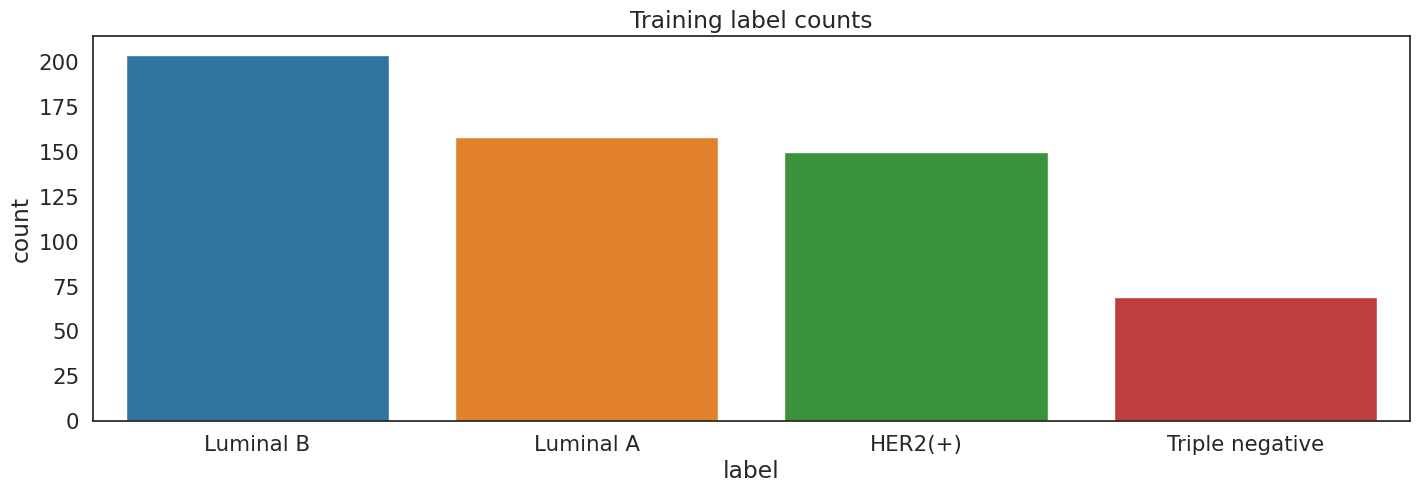

In [11]:
# Visualise the count of samples for each label
plt.figure(figsize = (17, 5))
sns.countplot(
    x = 'label',
    data = y_train,
    order = y_train['label'].value_counts().index,
    palette = "tab10"
)

# Set the title of the plot
plt.title("Training label counts")

# Display the plot
plt.show()

## 🔄 **Data Preprocessing**

In [12]:
# Define a mapping of label names to integers
le = LabelEncoder()
le.fit(y_train['label'])

# Map strings -> integers
y_train['label'] = le.transform(y_train['label'])

# Save mapping dict (string -> int) and reverse
label_to_int = {cls: i for i, cls in enumerate(le.classes_)}
int_to_label = {i: cls for i, cls in enumerate(le.classes_)}

print(label_to_int)

{'HER2(+)': 0, 'Luminal A': 1, 'Luminal B': 2, 'Triple negative': 3}


In [13]:
class_counts = y_train['label'].value_counts().sort_index()
total = class_counts.sum()

# Compute class weights
class_weights = total / class_counts
class_weights = class_weights / class_weights.sum()  # normalize
class_weights = torch.tensor(class_weights.values, dtype = torch.float32).to(device)

print(f"Class weights: {class_weights}")

Class weights: tensor([0.2058, 0.1954, 0.1513, 0.4474], device='cuda:0')


In [14]:
# Split samples into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = N_VAL,
    stratify = y_train['label'],
    random_state = SEED
)

# Print shapes of the datasets
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Label Shape: {y_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Validation Label Shape: {y_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

Training Data Shape: (464, 2)
Training Label Shape: (464, 2)
Validation Data Shape: (117, 2)
Validation Label Shape: (117, 2)
Test Data Shape: (477, 2)


### 🎭 Generative mask-conditioned synthesis
Use the provided binary masks as shape priors and let a pre-trained diffusion inpainting model redraw new textures inside them.
This grows the dataset with realistic variants while preserving slide geometry (shape = mask, texture = generated).

In [15]:
from huggingface_hub import login
from google.colab import userdata

print("Attempting login via Colab Secrets...")

try:
    # Recupera il token dai segreti di Colab (assicurati che la chiave si chiami 'HF_TOKEN')
    hf_token = userdata.get('HF_TOKEN')
    if hf_token:
        login(token=hf_token)
        print("Login successful!")
    else:
        print("Secret 'HF_TOKEN' not found or empty.")
except Exception as e:
    print(f"Login failed: {e}")
    print("Make sure you have added a secret named 'HF_TOKEN' in the Colab Secrets tab (key icon on the left).")

# Una volta fatto il login, riesegui la cella di generazione (quella sopra che inizia con 'Retry mask-conditioned synthesis').

Attempting login via Colab Secrets...
Login successful!


In [16]:
# --------------------------------------------------------
#  Detect already-generated synthetic variants (Drive + local)
# --------------------------------------------------------
if USE_MASK_CONDITIONED_SYNTH and SYNTH_SAMPLES_PER_IMAGE > 0:
  from google.colab import drive
  import os

  # 1. Mount Drive
  drive.mount('/content/drive')

  import re
  from collections import defaultdict

  RE_SYNTH = re.compile(r"^(?P<src>.+)_synth(?P<v>\d+)\.npy$")

  def collect_existing_synth_variants(*dirs):
      """
      Scans one or more directories and returns:
        - variants_by_source: dict {source_index: set(variant_int)}
        - files_seen: int total .npy files matched
      Assumes filenames like: {source_sample_index}_synth{v}.npy
      NOTE: files_seen counts matches across dirs (can double-count if same file exists in both).
      """
      variants_by_source = defaultdict(set)
      files_seen = 0

      for d in dirs:
          if (d is None) or (not os.path.exists(d)):
              continue

          for f in os.listdir(d):
              m = RE_SYNTH.match(f)
              if not m:
                  continue

              src = m.group("src")
              v   = int(m.group("v"))
              variants_by_source[src].add(v)
              files_seen += 1

      return dict(variants_by_source), files_seen


  def filter_existing_map_by_expected(existing_map, y_df, variations_per_class, base_default=3):
      """
      Filters/normalizes existing_map so it only contains "valid" variants in [0, expected-1],
      where expected is derived per-class via variations_per_class.

      Returns:
        - filtered_map: dict {source_index: set(valid_variant_int)}
        - report: dict with diagnostics (missing / extra / unknown sources)
      """
      label_lookup = y_df.set_index("sample_index")["label"].to_dict()

      filtered_map = {}
      missing = []
      extra = []
      unknown = []

      for src, have_set in existing_map.items():
          if src not in label_lookup:
              unknown.append(src)
              continue

          lbl = int(label_lookup[src])
          expected = int(variations_per_class.get(lbl, base_default))

          valid = {v for v in have_set if 0 <= v < expected}
          filtered_map[src] = valid

          # Diagnostics
          miss = [v for v in range(expected) if v not in valid]
          ext  = sorted([v for v in have_set if v < 0 or v >= expected])

          if miss:
              missing.append((src, lbl, expected, sorted(valid), miss))
          if ext:
              extra.append((src, lbl, expected, sorted(have_set), ext))

      report = {
          "missing": missing,
          "extra": extra,
          "unknown_sources": unknown,
      }
      return filtered_map, report


  # 2. Define paths
  synth_output_dir = "runtime/synth_mask/train"
  backup_dir = "/content/drive/MyDrive/AN2DL_C2_Synth_Backup"

  # --------------------------------------------------------
  #  Build "already processed" map from Drive backup (+ local)
  # --------------------------------------------------------
  existing_map_raw, n_seen = collect_existing_synth_variants(backup_dir, synth_output_dir)

  print(f"Found {n_seen} existing synth files across backup/local.")
  print(f"Unique source images already processed (raw): {len(existing_map_raw)}")



  # --------------------------------------------------------
  #  Keep ONLY "correct" variants according to per-class expected counts
  # --------------------------------------------------------
  class_counts = y_train['label'].value_counts()
  max_count = class_counts.max()
  variations_per_class = {}
  print("Dynamic variation strategy (min for all + more for rare):")
  for lbl, cnt in class_counts.items():
      # Base: defined by SYNTH_SAMPLES_PER_IMAGE
      # Add extra variations proportional to imbalance ratio
      ratio = max_count / cnt
      n_vars = int(SYNTH_SAMPLES_PER_IMAGE * ratio)

      # Cap max variations to avoid excessive generation (e.g., max 2x the base)
      n_vars = min(n_vars, SYNTH_SAMPLES_PER_IMAGE * 2)
      # Ensure at least base
      n_vars = max(n_vars, SYNTH_SAMPLES_PER_IMAGE)

      variations_per_class[lbl] = n_vars
      print(f"  Class {int_to_label[lbl]}: count={cnt} -> {n_vars} variations per image")

  existing_map, report = filter_existing_map_by_expected(
      existing_map_raw,
      y_train,
      variations_per_class,
      base_default=SYNTH_SAMPLES_PER_IMAGE  # fallback if class not in dict
  )

  print(f"Unique source images already processed (filtered): {len(existing_map)}")

  # Optional: keep a list of processed indices (what you asked for)
  already_processed_indices = sorted(existing_map.keys())

  # --------------------------------------------------------
  #  Quick diagnostic summary (so you immediately spot anomalies)
  # --------------------------------------------------------
  print(f"\nSources with missing variants: {len(report['missing'])}")
  for src, lbl, exp, have, miss in report["missing"]:
      print(f"  {src} | class={lbl} expected={exp} have={have} missing={miss}")

  print(f"\nSources with extra variants: {len(report['extra'])}")
  for src, lbl, exp, have, ext in report["extra"]:
      print(f"  {src} | class={lbl} expected={exp} have={have} extra={ext}")

  print(f"\nSources not found in y_train (ignored): {len(report['unknown_sources'])}")
  if report["unknown_sources"]:
      print("  Example:", report["unknown_sources"][:10])


Mounted at /content/drive
Found 413 existing synth files across backup/local.
Unique source images already processed (raw): 116
Dynamic variation strategy (min for all + more for rare):
  Class Luminal B: count=163 -> 3 variations per image
  Class Luminal A: count=126 -> 3 variations per image
  Class HER2(+): count=120 -> 4 variations per image
  Class Triple negative: count=55 -> 6 variations per image
Unique source images already processed (filtered): 116

Sources with missing variants: 1
  img_0536.png | class=3 expected=6 have=[0, 1, 2] missing=[3, 4, 5]

Sources with extra variants: 0

Sources not found in y_train (ignored): 0


In [17]:
import os
import pandas as pd
import numpy as np
from google.colab import drive

BACKUP_FOUND = False
# Configuration
backup_dir = "/content/drive/MyDrive/AN2DL_C2_Synth_Backup"
local_synth_dir = "runtime/synth_mask/train"
os.makedirs(local_synth_dir, exist_ok=True)

# Check if backup exists and is not empty
if os.path.exists(backup_dir) and len(os.listdir(backup_dir)) > 0:
    print(f"Backup trovato in: {backup_dir}. Avvio il ripristino...")

    # 1. Copy files from Drive to local runtime
    !cp -r -u -v "$backup_dir"/* "$local_synth_dir"

    # 2. Reconstruct dataframe metadata
    print("Ricostruzione metadati...")

    # Create a lookup for labels from the current y_train (assuming it contains original real data)
    # We need to filter out any existing synth labels to get a clean lookup for source images
    real_y_train = y_train[~y_train['sample_index'].str.contains('_synth')]
    label_lookup = real_y_train.set_index('sample_index')['label'].to_dict()

    restored_rows = []
    existing_samples = set(X_train['sample_index'].values)

    files = sorted([f for f in os.listdir(local_synth_dir) if f.endswith('.npy')])

    for f in files:
        # Filename format: {source_sample_index}_synth{v}.npy
        # Example: img_0123.png_synth00.npy

        synth_sample_index = f.replace('.npy', '')

        # Parse source index (everything before the last '_synth')
        if '_synth' in synth_sample_index:
            source_index = synth_sample_index.split('_synth')[0]
        else:
            # Fallback if naming convention is different
            continue

        # Retrieve label
        if source_index in label_lookup:
            label = label_lookup[source_index]

            # Avoid duplicates if already in X_train
            if synth_sample_index not in existing_samples:
                restored_rows.append({
                    'sample_index': synth_sample_index,
                    'image_path': os.path.join(local_synth_dir, f),
                    'label': label
                })

    # 3. Update X_train and y_train
    if restored_rows:
        synth_df = pd.DataFrame(restored_rows)

        X_train = pd.concat([X_train, synth_df[['sample_index', 'image_path']]], ignore_index=True)
        y_train = pd.concat([y_train, synth_df[['sample_index', 'label']]], ignore_index=True)

        print(f"\nRipristino completato!")
        print(f"Aggiunti {len(synth_df)} campioni sintetici recuperati.")
        print(f"Nuova dimensione training set: {len(X_train)}")
        BACKUP_FOUND = True

    else:
        print("\nI file sono stati copiati, ma nessun NUOVO campione è stato aggiunto (erano già in X_train o label non trovata).")

else:
    print(f"Nessun backup trovato in {backup_dir} (o cartella vuota).")
    print("Procedi con la generazione (esegui la cella 'Retry mask-conditioned synthesis').")

Backup trovato in: /content/drive/MyDrive/AN2DL_C2_Synth_Backup. Avvio il ripristino...
'/content/drive/MyDrive/AN2DL_C2_Synth_Backup/img_0003.png_synth00.npy' -> 'runtime/synth_mask/train/img_0003.png_synth00.npy'
'/content/drive/MyDrive/AN2DL_C2_Synth_Backup/img_0003.png_synth01.npy' -> 'runtime/synth_mask/train/img_0003.png_synth01.npy'
'/content/drive/MyDrive/AN2DL_C2_Synth_Backup/img_0003.png_synth02.npy' -> 'runtime/synth_mask/train/img_0003.png_synth02.npy'
'/content/drive/MyDrive/AN2DL_C2_Synth_Backup/img_0015.png_synth00.npy' -> 'runtime/synth_mask/train/img_0015.png_synth00.npy'
'/content/drive/MyDrive/AN2DL_C2_Synth_Backup/img_0015.png_synth01.npy' -> 'runtime/synth_mask/train/img_0015.png_synth01.npy'
'/content/drive/MyDrive/AN2DL_C2_Synth_Backup/img_0015.png_synth02.npy' -> 'runtime/synth_mask/train/img_0015.png_synth02.npy'
'/content/drive/MyDrive/AN2DL_C2_Synth_Backup/img_0030.png_synth00.npy' -> 'runtime/synth_mask/train/img_0030.png_synth00.npy'
'/content/drive/MyDrive

In [18]:
if not BACKUP_FOUND:

  # Mask-conditioned synthesis via diffusion inpainting (disabled by default)
  if USE_MASK_CONDITIONED_SYNTH and SYNTH_SAMPLES_PER_IMAGE > 0:
      try:
          from diffusers import StableDiffusionInpaintPipeline
      except ImportError:
          !pip install -q diffusers transformers accelerate xformers
          from diffusers import StableDiffusionInpaintPipeline

      from tqdm.auto import tqdm

      def _load_inpaint_pipeline(model_id=SYNTH_MODEL_ID):
          torch_dtype = torch.float16 if device.type == "cuda" else torch.float32
          pipe = StableDiffusionInpaintPipeline.from_pretrained(
              model_id,
              torch_dtype=torch_dtype,
              safety_checker=None,
          )
          pipe = pipe.to(device)

          # Performance optimization: xformers
          try:
              pipe.enable_xformers_memory_efficient_attention()
              print("Optimization enabled: xformers memory efficient attention.")
          except Exception as e:
              print(f"Could not enable xformers (falling back to slicing): {e}")
              pipe.enable_attention_slicing()

          pipe.set_progress_bar_config(disable=True)
          return pipe

      def generate_mask_conditioned_textures(
          X_df, y_df, prompt_by_class, out_dir,
          n_variations=1, seed=SEED, max_dim=1024, batch_size=3,
          existing_variants_by_source=None,  # NEW
      ):
          """
          Versione migliorata: preserva la risoluzione originale (arrotondata a multipli di 8).
          n_variations: int (same for all) or dict {label_id: int} (per-class variations).
          max_dim: dimensione massima lato maggiore per evitare OOM su GPU.
          batch_size: numero di varianti da generare in parallelo per singola immagine.

          NEW:
          - existing_variants_by_source: dict {source_index: set(variant_int)}
            If provided, generates ONLY missing variants (top-up strategy).
          """
          os.makedirs(out_dir, exist_ok=True)
          pipe = _load_inpaint_pipeline()
          label_lookup = y_df.set_index('sample_index')['label'].to_dict()
          records = []

          # NEW: avoid synth-of-synth (important if X_df already contains synth rows)
          X_df_real = X_df[~X_df['sample_index'].astype(str).str.contains('_synth')]

          print(f"Generating variations for {len(X_df_real)} images (Native Resolution, Batch Size {batch_size})...")

          for idx, row in tqdm(X_df_real.iterrows(), total=len(X_df_real), desc="Generating variations"):
              sample_id = row['sample_index']
              if sample_id not in label_lookup:
                  continue

              label_id = int(label_lookup[sample_id])
              prompt = prompt_by_class.get(label_id, SYNTH_BASE_PROMPT)

              # Determine number of variations for this specific class
              if isinstance(n_variations, dict):
                  n_vars = n_variations.get(label_id, 1)
              else:
                  n_vars = n_variations

              # NEW: compute which variants are missing (top-up, not all-or-nothing)
              already = set()
              if existing_variants_by_source is not None:
                  already = existing_variants_by_source.get(sample_id, set())

              needed_vars = [v for v in range(n_vars) if v not in already]
              if len(needed_vars) == 0:
                  continue  # all requested variants already exist

              arr = np.load(row['image_path'])
              rgb = arr[..., :3].astype(np.uint8)
              mask = arr[..., -1].astype(np.uint8)

              orig_h, orig_w = rgb.shape[:2]

              # 1. Calcola nuove dimensioni (multipli di 8)
              new_w = (orig_w // 8) * 8
              new_h = (orig_h // 8) * 8

              # 2. Check max dim (se troppo grande, scala mantenendo aspect ratio)
              if new_w > max_dim or new_h > max_dim:
                  scale = max_dim / max(new_w, new_h)
                  new_w = int((new_w * scale) // 8 * 8)
                  new_h = int((new_h * scale) // 8 * 8)

              init_image = Image.fromarray(rgb).convert('RGB')
              mask_image = Image.fromarray((mask > 0).astype(np.uint8) * 255).convert('L')

              # Resize to multiple of 8
              init_resized = init_image.resize((new_w, new_h), Image.BICUBIC)
              mask_resized = mask_image.resize((new_w, new_h), Image.NEAREST)

              # NEW: generators only for missing variants
              generators = [
                  torch.Generator(device=device).manual_seed(int(seed + v))
                  for v in needed_vars
              ]

              # Process in batches
              for i in range(0, len(needed_vars), batch_size):
                  batch_vars = needed_vars[i : i + batch_size]
                  batch_gens = generators[i : i + batch_size]
                  current_batch_size = len(batch_gens)

                  # Batch generation
                  result = pipe(
                      prompt=prompt,
                      negative_prompt=SYNTH_NEGATIVE_PROMPT,
                      image=init_resized,
                      mask_image=mask_resized,
                      guidance_scale=SYNTH_GUIDANCE_SCALE,
                      num_inference_steps=SYNTH_INFERENCE_STEPS,
                      generator=batch_gens,
                      num_images_per_prompt=current_batch_size,
                      height=new_h,
                      width=new_w
                  )

                  # Process batch results
                  for j, out_img in enumerate(result.images):
                      v = batch_vars[j]

                      # 3. Riporta alla dimensione originale esatta
                      out_resized = out_img.resize((orig_w, orig_h), Image.BICUBIC)
                      merged = np.dstack([np.array(out_resized).astype(np.uint8), mask])

                      synth_id = f"{sample_id}_synth{v:02d}"
                      out_path = os.path.join(out_dir, synth_id + '.npy')
                      np.save(out_path, merged.astype(np.uint8))

                      records.append({
                          'sample_index': synth_id,
                          'source_index': sample_id,
                          'image_path': out_path,
                          'label': label_id,
                          'prompt': prompt
                      })

          return pd.DataFrame(records)

      # NEW: Specific descriptions to guide the model towards correct histological features
      # 0: HER2(+), 1: Luminal A, 2: Luminal B, 3: Triple negative
      class_descriptions = {
          0: "high grade, pleomorphic nuclei, aggressive growth, dense cells",           # HER2(+)
          1: "low grade, well differentiated, tubular formation, classic pattern",       # Luminal A
          2: "intermediate grade, high cellularity, dense tissue structure",             # Luminal B
          3: "high grade, poorly differentiated, solid sheet growth, lymphocytic infiltration" # Triple negative
      }

      # Build rich prompts
      prompt_by_class = {}
      for lbl_id, description in class_descriptions.items():
          # Combine Base Prompt + Histological Description
          prompt_by_class[lbl_id] = f"{SYNTH_BASE_PROMPT}, {description}"

      synth_output_dir = "runtime/synth_mask/train"

      # Strategy: weighted generation to balance classes
      # Calculate class counts
      class_counts = y_train['label'].value_counts()
      max_count = class_counts.max()

      variations_per_class = {}
      print("Dynamic variation strategy (min for all + more for rare):")
      for lbl, cnt in class_counts.items():
          # Base: defined by SYNTH_SAMPLES_PER_IMAGE
          # Add extra variations proportional to imbalance ratio
          ratio = max_count / cnt
          n_vars = int(SYNTH_SAMPLES_PER_IMAGE * ratio)

          # Cap max variations to avoid excessive generation (e.g., max 2x the base)
          n_vars = min(n_vars, SYNTH_SAMPLES_PER_IMAGE * 2)
          # Ensure at least base
          n_vars = max(n_vars, SYNTH_SAMPLES_PER_IMAGE)

          variations_per_class[lbl] = n_vars
          print(f"  Class {int_to_label[lbl]}: count={cnt} -> {n_vars} variations per image")

      synth_df = generate_mask_conditioned_textures(
          X_train,
          y_train,
          prompt_by_class=prompt_by_class,
          out_dir=synth_output_dir,
          n_variations=variations_per_class,
          seed=SEED,
          batch_size=3,  # Process 3 variations at once
          existing_variants_by_source=existing_map,  # NEW
      )

      if len(synth_df) > 0:
          X_train = pd.concat([X_train, synth_df[['sample_index', 'image_path']]], ignore_index=True)
          y_train = pd.concat([y_train, synth_df[['sample_index', 'label']]], ignore_index=True)
          print(f"Added {len(synth_df)} mask-conditioned synthetic samples → train set now {len(X_train)} entries")
      else:
          print("Mask-conditioned synthesis produced no samples (check pipeline/params)")
  else:
      print("Mask-conditioned synthesis disabled. Set USE_MASK_CONDITIONED_SYNTH = True to enable.")
  from google.colab import drive
  import os

  # 1. Mount Drive
  drive.mount('/content/drive')

  # # 2. Define paths
  source_dir = "runtime/synth_mask/train"
  dest_dir = "/content/drive/MyDrive/AN2DL_C2_Synth_Backup"

  # 3. Check and Copy
  if os.path.exists(source_dir) and len(os.listdir(source_dir)) > 0:
      num_files = len(os.listdir(source_dir))
      print(f"Trovati {num_files} file. Avvio copia su Drive in: {dest_dir}...")

      # Create dest if not exists
      os.makedirs(dest_dir, exist_ok=True)

      # Copy files using shell command (cp -r) for efficiency
      # -u updates only new/changed files, -v is verbose
      !cp -r -u -v "$source_dir"/* "$dest_dir"

      print("\nBackup completato!")
  else:
      print("La cartella sorgente è vuota o non esiste. Nessun file da copiare.")


#### 🔍 Visualise synthetic samples

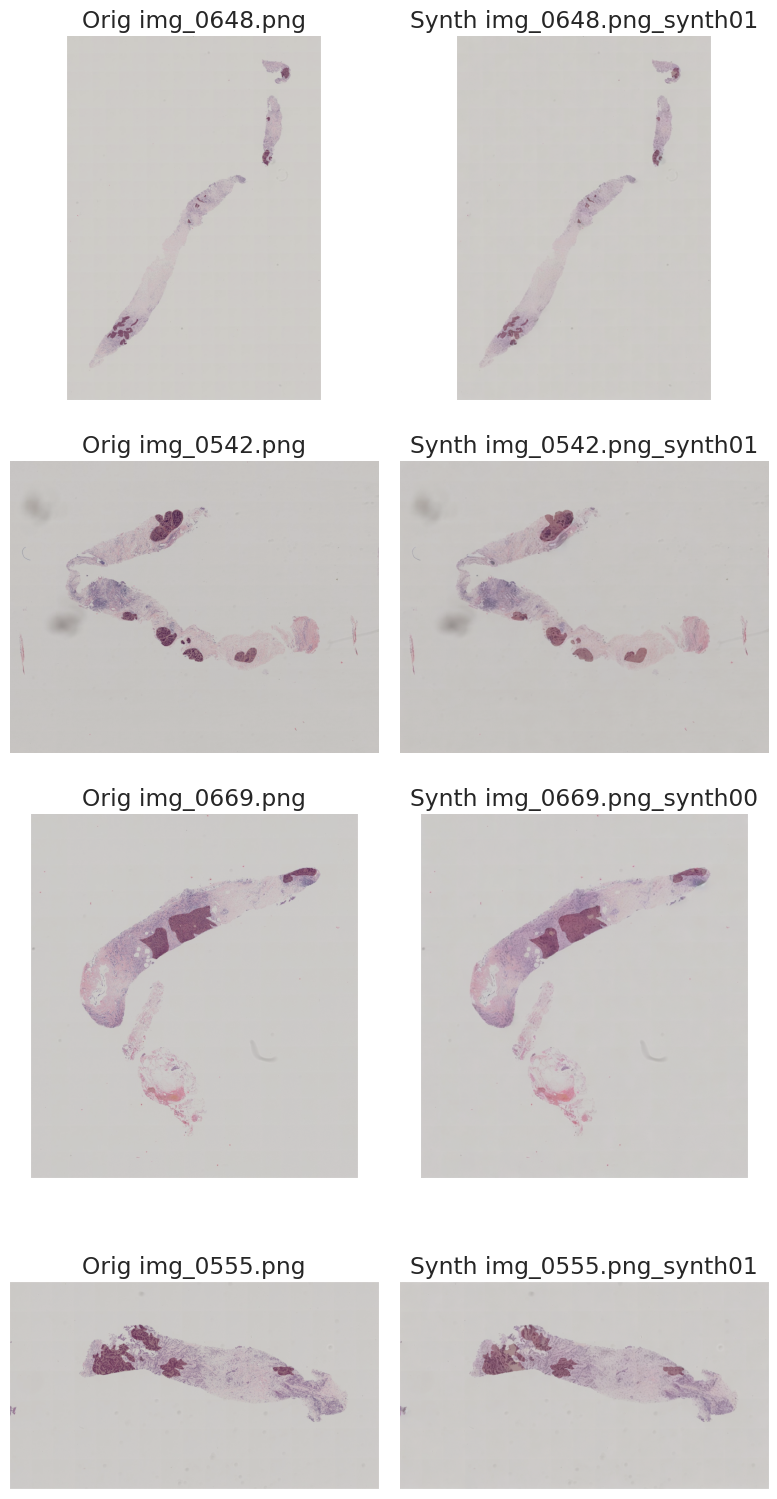

In [19]:
def visualize_mask_conditioned_samples(df, base_df, n=20):
    """Mostra coppie (originale vs sintetico) con maschera overlay.
    df: synth_df prodotto dalla cella precedente
    base_df: X_train con path verso i .npy
    """
    if df is None or len(df) == 0:
        print("Nessuna immagine sintetica disponibile (abilita USE_MASK_CONDITIONED_SYNTH e riesegui).")
        return

    import math
    import matplotlib.pyplot as plt

    # Seleziona subset
    n_show = min(n, len(df))
    subset = df.sample(n_show, random_state=SEED)

    fig, axes = plt.subplots(n_show, 2, figsize=(8, 4 * n_show))
    if n_show == 1:
        axes = axes.reshape(1, 2)

    for ax_row, (_, row) in zip(axes, subset.iterrows()):
        synth = np.load(row['image_path'])
        synth_rgb, synth_mask = synth[..., :3], synth[..., -1]

        # Trova originale
        source_idx = row.get('source_index', None)

        # NEW: handle NaN / missing source_index by parsing from sample_index
        if source_idx is None or (isinstance(source_idx, float) and np.isnan(source_idx)):
            if '_synth' in row['sample_index']:
                source_idx = row['sample_index'].split('_synth')[0]
            else:
                source_idx = None

        orig_rgb = orig_mask = None
        if source_idx is not None:
            try:
                # NOTE: base_df must contain original rows with sample_index == source_idx
                orig_path = base_df.loc[base_df['sample_index'] == source_idx, 'image_path'].iloc[0]
                orig = np.load(orig_path)
                orig_rgb, orig_mask = orig[..., :3], orig[..., -1]
            except Exception as e:  # noqa: F841
                orig_rgb = orig_mask = None

        # Plot originale
        ax_orig, ax_synth = ax_row
        if orig_rgb is not None:
            ax_orig.imshow(orig_rgb.astype(np.uint8))
            ax_orig.imshow(orig_mask, cmap='Reds', alpha=0.25)
            ax_orig.set_title(f"Orig {source_idx}")
        else:
            ax_orig.text(0.5, 0.5, f"Origine non trovata\n({source_idx})", ha='center')
        ax_orig.axis('off')

        # Plot sintetico
        ax_synth.imshow(synth_rgb.astype(np.uint8))
        ax_synth.imshow(synth_mask, cmap='Reds', alpha=0.25)
        ax_synth.set_title(f"Synth {row['sample_index']}")
        ax_synth.axis('off')

    plt.tight_layout()
    plt.show()


# Esegui la visualizzazione solo se disponibile synth_df
if 'synth_df' in globals():
    visualize_mask_conditioned_samples(synth_df, X_train, n=4)
else:
    print("synth_df non definito: esegui prima la cella di generazione.")


### Patches building

In [20]:
def crop_patches(X, output,
                 patch_size = 128,
                 patches_per_img = 10,
                 max_mask_dist = None,
                 min_patches_dist = None,
                 keep_mask = True,
                 random_state = 42):
    """
    From a dataframe X containing images (image + mask), extract small crops
    centered on white mask pixels, generating patches_per_img crops per original image.

    Returns a dataframe with columns:
        - sample_index (same as original)
        - crop_index (unique per image)
        - crop (the cropped image path)
    """
    rng = random.Random(random_state)
    half = patch_size // 2

    if max_mask_dist is None:
        max_mask_dist = patch_size // 2

    if min_patches_dist is None:
        min_patches_dist = patch_size // 4

    results = []

    for _, row in X.iterrows():
        image = load_image(row['image_path'], normalize = False)   # shape: (H, W, C)
        sample_index = row['sample_index']

        H, W, C = image.shape

        # Extract the mask (last channel by default)
        mask = image[:, :, -1]

        # Coordinates within mask
        ys, xs = np.where(mask > 0)
        coords = list(zip(xs, ys))

        # Choose random mask pixels
        sample_coords = rng.sample(coords, min(patches_per_img * 4, len(coords)))

        scored_crops = []

        for (cx, cy) in sample_coords:
            # Random shift within max_mask_dist
            dx = rng.randint(-max_mask_dist, max_mask_dist)
            dy = rng.randint(-max_mask_dist, max_mask_dist)
            cx_shifted = np.clip(cx + dx, half, W - half)
            cy_shifted = np.clip(cy + dy, half, H - half)

            # Crop boundaries
            x1 = cx_shifted - half
            x2 = cx_shifted + half
            y1 = cy_shifted - half
            y2 = cy_shifted + half

            # Ensure crop inside image boundaries
            if x1 < 0 or y1 < 0 or x2 > W or y2 > H:
                continue

            if keep_mask:
                crop = image[y1:y2, x1:x2, :]
            else:
                crop = image[y1:y2, x1:x2, :(C - 1)]   # keep only image channels

            # Convert to single-byte
            crop = crop.astype(np.uint8)

            # Compute mask ratio
            crop_mask = mask[y1:y2, x1:x2]
            mask_ratio = crop_mask.mean() / mask.max()

            scored_crops.append({
                    "crop": crop,
                    "ratio": mask_ratio,
                    "center": (cx_shifted, cy_shifted)
                })

        # Sort by mask ratio descending
        scored_crops.sort(key = lambda x: x['ratio'], reverse = True)

        selected_crops = []

        for item in scored_crops:
            cx, cy = item['center']

            # check distance from already selected patches
            too_close = False
            for s in selected_crops:
                x2, y2 = s['center']
                if (cx - x2)**2 + (cy - y2)**2 < min_patches_dist**2:
                    too_close = True
                    break

            if not too_close:
                selected_crops.append(item)

            if len(selected_crops) == patches_per_img:
                break

        for i, item in enumerate(selected_crops, start = 1):
            crop = item['crop']
            crop_index = f"{sample_index}_crop_{i:02d}"
            out_path = os.path.join(output, f"{crop_index}.npy")
            np.save(out_path, crop)

            results.append({
                "sample_index": sample_index,
                "crop_index": crop_index,
                "image_path": out_path
            })

    return pd.DataFrame(results).sort_values('crop_index').reset_index(drop = True)

In [21]:
%%time
# Build cropped patches
X_c_train = crop_patches(X_train, "runtime/crop/train",
                         patch_size = PATCH_SIZE,
                         patches_per_img = PATCHES_PER_IMG,
                         max_mask_dist = MAX_MASK_DIST,
                         min_patches_dist = MIN_PATCHES_DIST,
                         keep_mask = KEEP_MASK,
                         random_state = SEED)
X_c_val   = crop_patches(X_val, "runtime/crop/train",
                         patch_size = PATCH_SIZE,
                         patches_per_img = PATCHES_PER_IMG,
                         max_mask_dist = MAX_MASK_DIST,
                         min_patches_dist = MIN_PATCHES_DIST,
                         keep_mask = KEEP_MASK,
                         random_state = SEED)
X_c_test  = crop_patches(X_test, "runtime/crop/test",
                         patch_size = PATCH_SIZE,
                         patches_per_img = PATCHES_PER_IMG,
                         max_mask_dist = MAX_MASK_DIST,
                         min_patches_dist = MIN_PATCHES_DIST,
                         keep_mask = KEEP_MASK,
                         random_state = SEED)

y_c_train = X_c_train[['sample_index']].merge(y_train, on = 'sample_index', how = "left")
y_c_val   = X_c_val[['sample_index']]  .merge(y_val,   on = 'sample_index', how = "left")

# Print shapes of the datasets
print(f"Training Data Shape: {X_c_train.shape}")
print(f"Training Label Shape: {y_c_train.shape}")
print(f"Validation Data Shape: {X_c_val.shape}")
print(f"Validation Label Shape: {y_c_val.shape}")
print(f"Test Data Shape: {X_c_test.shape}")

Training Data Shape: (7269, 3)
Training Label Shape: (7269, 2)
Validation Data Shape: (973, 3)
Validation Label Shape: (973, 2)
Test Data Shape: (3955, 3)
CPU times: user 1min 17s, sys: 5.2 s, total: 1min 22s
Wall time: 2min 1s


In [22]:
X_c_train

sample_index            crop_index  \
0     img_0000.png  img_0000.png_crop_01   
1     img_0000.png  img_0000.png_crop_02   
2     img_0000.png  img_0000.png_crop_03   
3     img_0000.png  img_0000.png_crop_04   
4     img_0000.png  img_0000.png_crop_05   
...            ...                   ...   
7264  img_0688.png  img_0688.png_crop_03   
7265  img_0688.png  img_0688.png_crop_04   
7266  img_0688.png  img_0688.png_crop_05   
7267  img_0688.png  img_0688.png_crop_06   
7268  img_0688.png  img_0688.png_crop_07   

                                       image_path  
0     runtime/crop/train/img_0000.png_crop_01.npy  
1     runtime/crop/train/img_0000.png_crop_02.npy  
2     runtime/crop/train/img_0000.png_crop_03.npy  
3     runtime/crop/train/img_0000.png_crop_04.npy  
4     runtime/crop/train/img_0000.png_crop_05.npy  
...                                           ...  
7264  runtime/crop/train/img_0688.png_crop_03.npy  
7265  runtime/crop/train/img_0688.png_crop_04.npy  
7266  runtime/crop/train/img_0688.png_crop_05.npy  
7267  runtime/crop/train/img_0688.png_crop_06.npy  
7268  runtime/crop/train/img_0688.png_crop_07.npy  

[7269 rows x 3 columns]

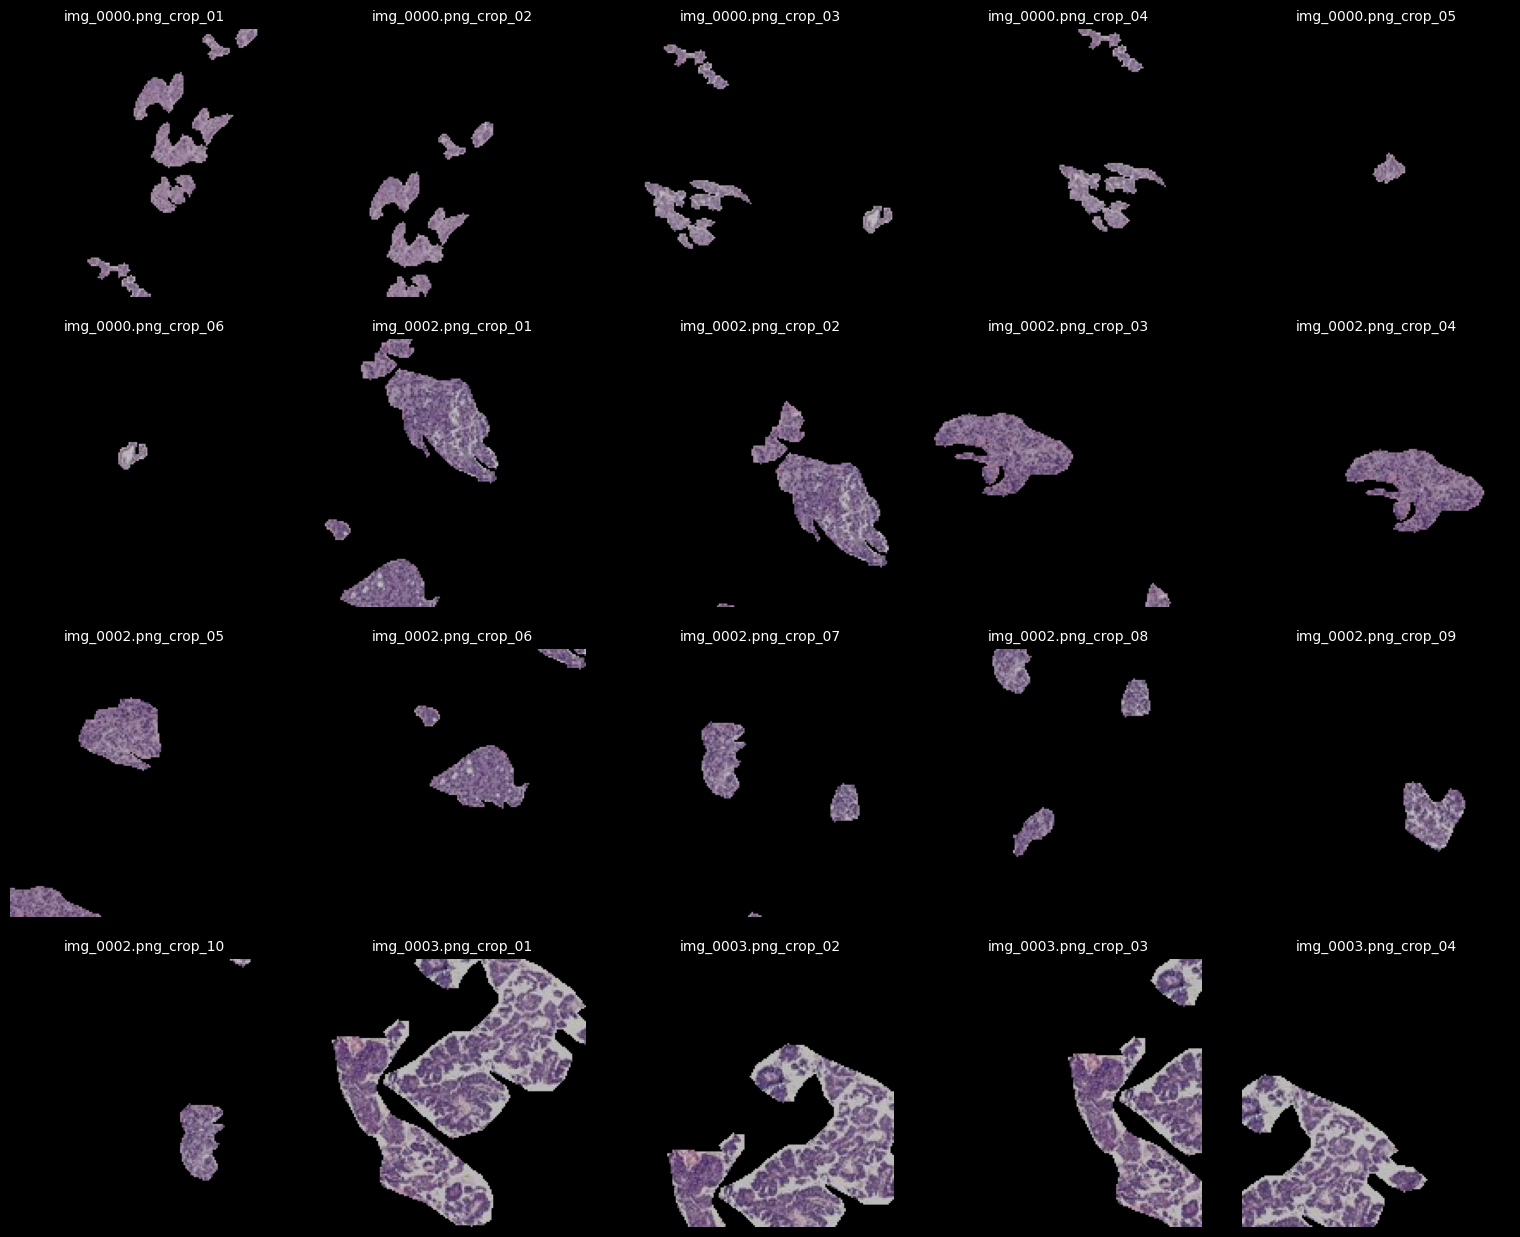

In [23]:
plot_images(X_c_train, index_column = 'crop_index')

In [24]:
class_counts = y_c_train['label'].value_counts().sort_index()
total = class_counts.sum()
print("Class counts (patch-level):", class_counts.to_dict())

class_weights = total / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)
print(f"Class weights (normalized, NOT used in loss): {class_weights}")

# --------- NUOVO: pesi per WeightedRandomSampler ---------
# labels per ogni sample, nello stesso ordine del tuo dataframe y_c_train
labels_np = y_c_train['label'].values.astype(int)
labels_tensor = torch.from_numpy(labels_np)  # shape: (N,)

# Peso per classe = 1 / freq(classe)
counts_tensor = torch.tensor(class_counts.values, dtype=torch.float32)  # shape: (num_classes,)
class_inv_freq = 1.0 / torch.sqrt(counts_tensor)
# Peso per ogni sample = peso della sua classe
sample_weights = class_inv_freq[labels_tensor]  # shape: (N,)

train_sampler = WeightedRandomSampler(
    weights = sample_weights,
    num_samples = len(sample_weights),
    replacement = True,
)

print("Train sampler ready.")


Class counts (patch-level): {0: 1968, 1: 1815, 2: 2463, 3: 1023}
Class weights (normalized, NOT used in loss): tensor([0.2080, 0.2256, 0.1662, 0.4002], device='cuda:0')
Train sampler ready.


### PyTorch datasets

In [25]:
# Define the input shape based on the training data
H, W, C = load_image(X_c_train.loc[0, 'image_path']).shape
input_shape = (C, H, W)

# Define the number of classes
num_classes = len(np.unique(y_c_train['label']))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (4, 156, 156)
Number of Classes: 4


In [26]:
from torch.utils.data import Dataset

class PatchTensorDataset(Dataset):
    """
    Dataset basato su array numpy già caricati:
    - images: numpy (N, H, W, C)
    - img_ids: array/list (N,) con sample_index originale (stringa o int)
    - labels: numpy (N,) con etichette (opzionale per test)
    """
    def __init__(self, images, img_ids, labels=None):
        # Salvo le immagini come tensor (N, C, H, W)
        self.images = torch.from_numpy(images).permute(0, 3, 1, 2).float()

        # img_ids può essere np.array di object (es. "img_0001.png"):
        # lo manteniamo come semplice lista Python, NON come tensor.
        self.img_ids = list(img_ids)

        if labels is not None:
            self.labels = torch.from_numpy(labels).long()
        else:
            self.labels = None

    def __len__(self):
        return self.images.size(0)

    def __getitem__(self, idx):
        x = self.images[idx]
        img_id = self.img_ids[idx]   # stringa o int, va bene così

        if self.labels is None:
            # Test set: non abbiamo label
            return img_id, x
        else:
            y = self.labels[idx]
            return img_id, x, y


In [27]:
train_ids = X_c_train["sample_index"].to_numpy()
val_ids   = X_c_val["sample_index"].to_numpy()
test_ids  = X_c_test["sample_index"].to_numpy()

In [28]:
X_train_array = np.stack(X_c_train['image_path'].apply(lambda i: load_image(i)).values)
X_val_array   = np.stack(X_c_val['image_path']  .apply(lambda i: load_image(i)).values)
X_test_array  = np.stack(X_c_test['image_path'] .apply(lambda i: load_image(i)).values)

y_train_array = np.array(y_c_train['label'])
y_val_array   = np.array(y_c_val['label'])

# Convert numpy arrays to PyTorch datasets (without augmentation for now)
# train_ds_base = TensorDataset(
#     torch.from_numpy(X_train_array).permute(0, 3, 1, 2),
#     torch.from_numpy(y_train_array).squeeze().long()
# )
# val_ds = TensorDataset(
#     torch.from_numpy(X_val_array).permute(0, 3, 1, 2),
#     torch.from_numpy(y_val_array).squeeze().long()
# )
# test_ds = TensorDataset(
#     torch.from_numpy(X_test_array).permute(0, 3, 1, 2)
# )

# Costruisci i dataset base mantenendo img_id (sample_index)
train_ds_base = PatchTensorDataset(
    images  = X_train_array,
    img_ids = train_ids,
    labels  = y_train_array
)

val_ds_base = PatchTensorDataset(
    images  = X_val_array,
    img_ids = val_ids,
    labels  = y_val_array
)

test_ds_base = PatchTensorDataset(
    images  = X_test_array,
    img_ids = test_ids,
    labels  = None
)


Train patches per classe:
  HER2(+): 1968 patch (27.1%)
  Luminal A: 1815 patch (25.0%)
  Luminal B: 2463 patch (33.9%)
  Triple negative: 1023 patch (14.1%)

Val patches per classe:
  HER2(+): 257 patch (26.4%
  Luminal A: 264 patch (27.1%
  Luminal B: 336 patch (34.5%
  Triple negative: 116 patch (11.9%


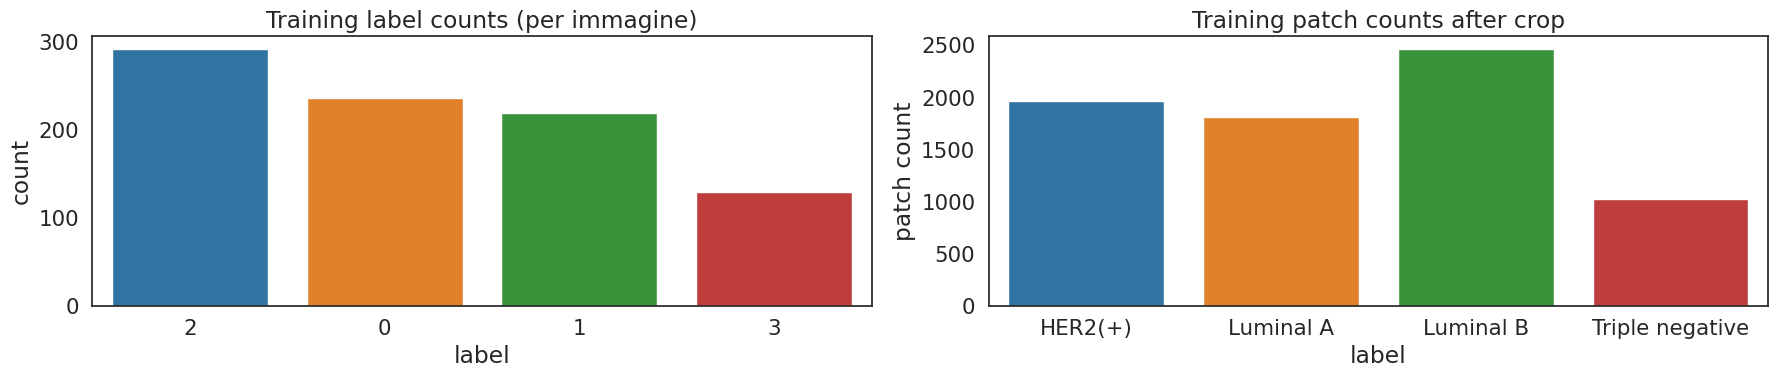

In [29]:
from collections import Counter
# -------------------------
# 1) Conteggi patch (dopo crop)
# -------------------------
train_counts = Counter(y_train_array.tolist())
val_counts   = Counter(y_val_array.tolist())

classes      = sorted(train_counts.keys())
class_names  = [int_to_label[c] for c in classes]

print("Train patches per classe:")
train_total = len(y_train_array)
for c in classes:
    name = int_to_label[c]
    cnt = train_counts[c]
    print(f"  {name}: {cnt} patch ({cnt/train_total*100:.1f}%)")

print("\nVal patches per classe:")
val_total = len(y_val_array)
for c in classes:
    name = int_to_label[c]
    cnt = val_counts[c]
    print(f"  {name}: {cnt} patch ({cnt/val_total*100:.1f}%")

# -------------------------
# 2) Grafici BEFORE vs AFTER nella stessa figura
# -------------------------
plt.figure(figsize=(18, 4))

# BEFORE (per immagine, y_train DataFrame)
plt.subplot(1, 2, 1)
sns.countplot(
    x='label',
    data=y_train,          # colonne string (Luminal A, ...)
    order=y_train['label'].value_counts().index,
    palette="tab10"
)
plt.title("Training label counts (per immagine)")
plt.xlabel("label")
plt.ylabel("count")

# AFTER (per patch, usando class_names)
plt.subplot(1, 2, 2)
sns.barplot(
    x=class_names,
    y=[train_counts[c] for c in classes],
    palette="tab10"
)
plt.title("Training patch counts after crop")
plt.xlabel("label")
plt.ylabel("patch count")

plt.tight_layout()
plt.show()

## 💪 **Image Augmentation**

### Geometric and color augmentation

In [30]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


class ImageNetNormalize:
    """
    Normalizza i primi 3 canali RGB con mean/std di ImageNet.
    Il canale mask (se presente) viene lasciato invariato.
    """
    def __init__(self, mean=IMAGENET_MEAN, std=IMAGENET_STD):
        self.mean = torch.tensor(mean, dtype=torch.float32).reshape(3, 1, 1)
        self.std = torch.tensor(std, dtype=torch.float32).reshape(3, 1, 1)

    def __call__(self, image):
        """
        Args:
            image: torch.Tensor di shape (C, H, W)
                   dove C=4 (RGB + mask) o C=3 (solo RGB)
        Returns:
            image: torch.Tensor normalizzato
        """
        C = image.shape[0]

        if C == 4:
            # Separa RGB e mask
            rgb = image[:3]      # (3, H, W)
            mask = image[3:4]    # (1, H, W)

            # Normalizza solo RGB
            rgb_normalized = (rgb - self.mean) / self.std

            # Ricombina
            image = torch.cat([rgb_normalized, mask], dim=0)
        else:
            # Solo RGB, normalizza tutto
            image = (image - self.mean) / self.std

        return image

In [31]:
class AugmentedDataset(torch.utils.data.Dataset):
    """
    Dataset wrapper that applies augmentation transforms to images.
    """
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        sample = self.base_dataset[idx]

        if len(sample) == 3:
            # Training/validation: (img_id, image, label)
            img_id, image, label = sample
            if self.transform:
                image = self.transform(image)
            return img_id, image, label

        elif len(sample) == 2:
            # Test: (img_id, image)
            img_id, image = sample
            if self.transform:
                image = self.transform(image)
            return img_id, image

        else:
            raise ValueError(f"Unexpected sample length: {len(sample)}")


In [32]:
class RandAugment:
    """
    RandAugment for histopathology: geo su tutti canali, color SOLO bright/contr (stain-safe).
    """
    def __init__(self):
        # Geometric (all channels, histo-safe)
        self.geometric_ops = [
            ('rotate', lambda image, mag: transforms.functional.rotate(
                image, angle=float(mag)*25-12.5,
                interpolation=transforms.InterpolationMode.BILINEAR
            )),
            ('translate_x', lambda image, mag: transforms.functional.affine(
                image, angle=0, translate=[int(mag*image.shape[-1]*0.15), 0],
                scale=1.0, shear=0, interpolation=transforms.InterpolationMode.BILINEAR
            )),
            ('translate_y', lambda image, mag: transforms.functional.affine(
                image, angle=0, translate=[0, int(mag*image.shape[-2]*0.15)],
                scale=1.0, shear=0, interpolation=transforms.InterpolationMode.BILINEAR
            )),
            ('shear_x', lambda image, mag: transforms.functional.affine(
                image, angle=0, translate=[0,0],
                scale=1.0, shear=[float(mag)*15-7.5, 0],
                interpolation=transforms.InterpolationMode.BILINEAR
            )),
            ('shear_y', lambda image, mag: transforms.functional.affine(
                image, angle=0, translate=[0,0],
                scale=1.0, shear=[0, float(mag)*15-7.5],
                interpolation=transforms.InterpolationMode.BILINEAR
            )),
        ]

        # SOLO bright/contrast (no hue/sat: preserva stain!)
        self.color_ops = [
            ('brightness', lambda image, mag: transforms.functional.adjust_brightness(
                image, 1.0 + float(mag)*0.15 - 0.075  # ±7.5%
            )),
            ('contrast', lambda image, mag: transforms.functional.adjust_contrast(
                image, 1.0 + float(mag)*0.15 - 0.075
            )),
        ]




In [33]:
class ImageRandAugment:
    """
    RandAugment histo-tuned (stessa API, drop-in replace).
    """
    def __init__(self, n_geometric=2, n_color=2, mag_geometric=10, mag_color=8, keep_mask=True):
        self.rand_augment = RandAugment()
        self.n_geometric = n_geometric
        self.n_color = n_color
        self.mag_geometric = mag_geometric
        self.mag_color = mag_color
        self.keep_mask = keep_mask

        self.base_geometric = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
        ])

    def __call__(self, image):
        """
        Applica le trasformazioni geometriche in modo sincrono a img e mask
        (mask sempre con interpolazione nearest per rimanere binaria), e
        le trasformazioni di colore solo all'immagine.
        """
        # Split img/mask
        C, _, _ = image.shape
        img = image[:(C-1)] if self.keep_mask else image
        mask = image[-1:] if self.keep_mask else None

        # Flips condivisi
        if random.random() < 0.5:
            img = transforms.functional.hflip(img)
            if mask is not None:
                mask = transforms.functional.hflip(mask)
        if random.random() < 0.5:
            img = transforms.functional.vflip(img)
            if mask is not None:
                mask = transforms.functional.vflip(mask)

        # Geo ops (stessi parametri, interp bilinear per img, nearest per mask)
        geo_ops = ["rotate", "translate_x", "translate_y", "shear_x", "shear_y"]
        if self.n_geometric > 0:
            ops = random.choices(geo_ops, k=self.n_geometric)
            for op_name in ops:
                mag = random.uniform(0, self.mag_geometric) / self.mag_geometric
                if op_name == "rotate":
                    angle = float(mag) * 25 - 12.5
                    img = transforms.functional.rotate(
                        img, angle=angle, interpolation=transforms.InterpolationMode.BILINEAR
                    )
                    if mask is not None:
                        mask = transforms.functional.rotate(
                            mask, angle=angle, interpolation=transforms.InterpolationMode.NEAREST, fill=0
                        )
                elif op_name == "translate_x":
                    shift = int(mag * img.shape[-1] * 0.15)
                    img = transforms.functional.affine(
                        img, angle=0, translate=[shift, 0], scale=1.0, shear=0,
                        interpolation=transforms.InterpolationMode.BILINEAR
                    )
                    if mask is not None:
                        mask = transforms.functional.affine(
                            mask, angle=0, translate=[shift, 0], scale=1.0, shear=0,
                            interpolation=transforms.InterpolationMode.NEAREST, fill=0
                        )
                elif op_name == "translate_y":
                    shift = int(mag * img.shape[-2] * 0.15)
                    img = transforms.functional.affine(
                        img, angle=0, translate=[0, shift], scale=1.0, shear=0,
                        interpolation=transforms.InterpolationMode.BILINEAR
                    )
                    if mask is not None:
                        mask = transforms.functional.affine(
                            mask, angle=0, translate=[0, shift], scale=1.0, shear=0,
                            interpolation=transforms.InterpolationMode.NEAREST, fill=0
                        )
                elif op_name == "shear_x":
                    shear = float(mag) * 15 - 7.5
                    img = transforms.functional.affine(
                        img, angle=0, translate=[0, 0], scale=1.0, shear=[shear, 0],
                        interpolation=transforms.InterpolationMode.BILINEAR
                    )
                    if mask is not None:
                        mask = transforms.functional.affine(
                            mask, angle=0, translate=[0, 0], scale=1.0, shear=[shear, 0],
                            interpolation=transforms.InterpolationMode.NEAREST, fill=0
                        )
                elif op_name == "shear_y":
                    shear = float(mag) * 15 - 7.5
                    img = transforms.functional.affine(
                        img, angle=0, translate=[0, 0], scale=1.0, shear=[0, shear],
                        interpolation=transforms.InterpolationMode.BILINEAR
                    )
                    if mask is not None:
                        mask = transforms.functional.affine(
                            mask, angle=0, translate=[0, 0], scale=1.0, shear=[0, shear],
                            interpolation=transforms.InterpolationMode.NEAREST, fill=0
                        )

        # Color SOLO img
        if self.n_color > 0:
            ops = random.choices(self.rand_augment.color_ops, k=self.n_color)
            for _, op in ops:
                mag = random.uniform(0, self.mag_color) / self.mag_color
                img = op(img, mag)

        # Ricombina e ri-binarizza la mask (0/1)
        if self.keep_mask and mask is not None:
            mask = (mask > 0.5 if mask.max() <= 1 else mask > 127).float()
            return torch.cat([img, mask], dim=0)
        return img

In [34]:

# Create transform
train_transform = ImageRandAugment(
    n_geometric = N_GEOMETRIC,      # n of geometric operations (rotate/translate/shear)
    n_color = N_COLOR,              # n of color operations (brightness/contrast/etc)
    mag_geometric = MAG_GEOMETRIC,
    mag_color = MAG_COLOR,
    keep_mask = KEEP_MASK
)

In [35]:
# Crea la transform di normalizzazione
normalize_transform = ImageNetNormalize()

# Applica al training set (DOPO le augmentazioni)
train_ds_aug = AugmentedDataset(
    train_ds_base,
    transform=transforms.Compose([
        train_transform,        # Prima le augmentazioni
        normalize_transform     # Poi la normalizzazione
    ])
)

# apply to validation e test
val_ds = AugmentedDataset(
    val_ds_base,
    transform=normalize_transform  # only normalization, no augmentation
)

test_ds = AugmentedDataset(
    test_ds_base,
    transform=normalize_transform  # Solo normalizzazione, no augmentazioni
)

print(f"\nDatasets:")
print(f"  Training:   {len(train_ds_aug):>6,} samples (with RandAugment)")
print(f"  Validation: {len(val_ds):>6,} samples (no augmentation)")
print(f"  Test:       {len(test_ds):>6,} samples (no augmentation)")


Datasets:
  Training:    7,269 samples (with RandAugment)
  Validation:    973 samples (no augmentation)
  Test:        3,955 samples (no augmentation)


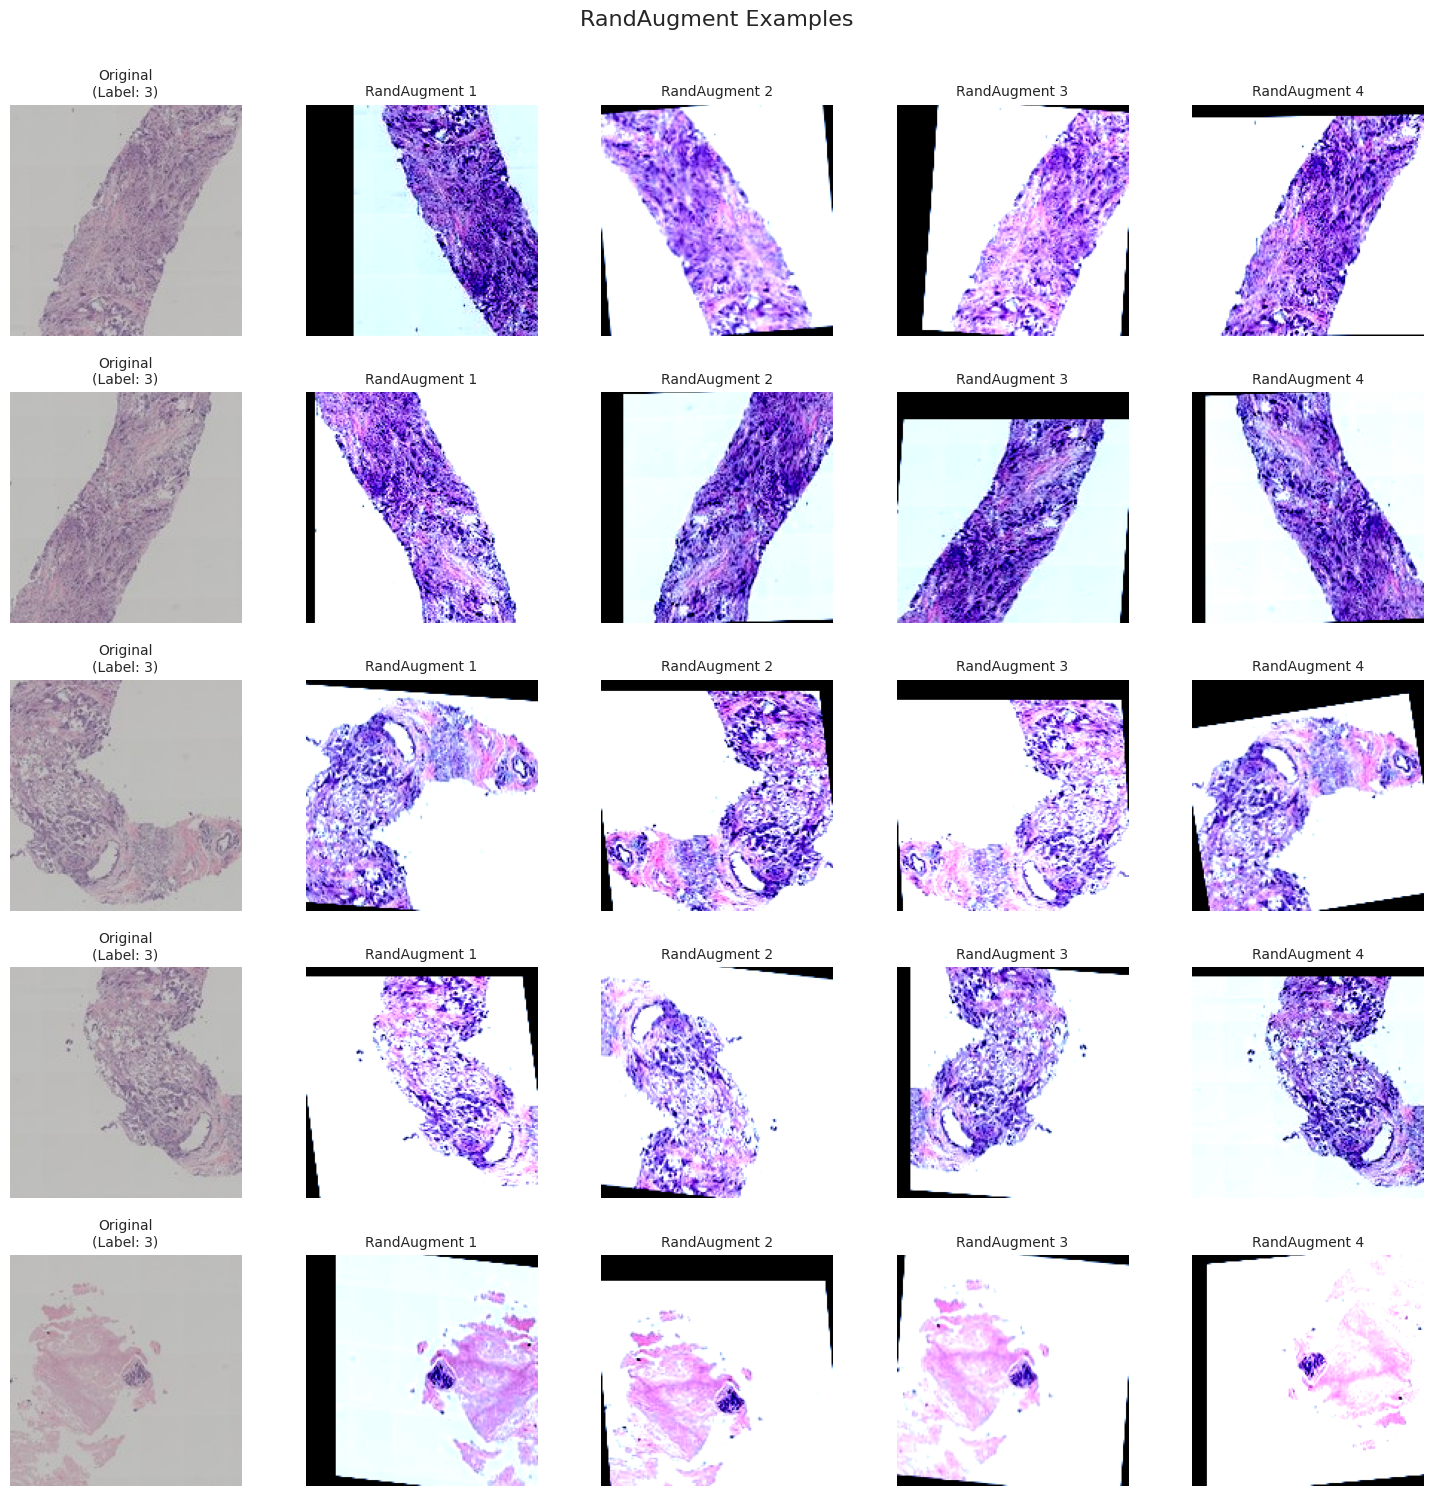

In [36]:
def visualize_augmentations(dataset,
                            num_samples = 5,
                            augmentations_per_sample = 4,
                            keep_mask = True):
    """
    Visualize original and augmented versions of training samples.

    Args:
        dataset: AugmentedDataset instance
        num_samples: Number of different samples to show
        augmentations_per_sample: Number of augmented versions per sample
        keep_mask: Whether images have their mask as a last channel
    """
    fig, axes = plt.subplots(
        num_samples,
        augmentations_per_sample + 1,
        figsize = (3 * (augmentations_per_sample + 1), 3 * num_samples),
        facecolor = "white"
    )

    # Handle single row case
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # --------------------------------------
        # Get original sample (before augmentation)
        # --------------------------------------
        base_sample = dataset.base_dataset[i]

        # Retrocompatibilità:
        # - vecchio caso: (image, label)
        # - nuovo caso:   (img_id, image, label)
        if len(base_sample) == 3:
            _, image, label = base_sample
        elif len(base_sample) == 2:
            image, label = base_sample
        else:
            raise ValueError(f"Unexpected base sample length: {len(base_sample)}")

        # Number of channels (per gestire optional mask)
        C_local = image.shape[0]  # image è tensor (C, H, W)

        # Remove mask (if present)
        if keep_mask and C_local > 3:
            image = image[:(C_local - 1)]

        # Convert grayscale to 3-channel RGB (se mai arrivasse come 1×H×W)
        if image.ndim == 2:
            # grayscale → stack 3 channels
            image = np.stack([image, image, image], axis = -1)

        # Show original
        img = image.permute(1, 2, 0).numpy()
        axes[i, 0].imshow(np.clip(img, 0, 1))
        axes[i, 0].set_title(f"Original\n(Label: {label.item()})", fontsize = 10)
        axes[i, 0].axis('off')

        # --------------------------------------
        # Show augmented versions
        # --------------------------------------
        for j in range(augmentations_per_sample):
            aug_sample = dataset[i]

            # Retrocompatibilità:
            # - vecchio caso: (image_aug, label_aug)
            # - nuovo caso:   (img_id, image_aug, label_aug)
            if len(aug_sample) == 3:
                _, image_aug, _ = aug_sample
            elif len(aug_sample) == 2:
                image_aug, _ = aug_sample
            else:
                raise ValueError(f"Unexpected augmented sample length: {len(aug_sample)}")

            C_aug = image_aug.shape[0]

            # Remove mask (if present)
            if keep_mask and C_aug > 3:
                image_aug = image_aug[:(C_aug - 1)]

            # Convert grayscale to 3-channel RGB (se mai arrivasse come 1×H×W)
            if image_aug.ndim == 2:
                image_aug = np.stack([image_aug, image_aug, image_aug], axis = -1)

            img_aug = image_aug.permute(1, 2, 0).numpy()
            axes[i, j + 1].imshow(np.clip(img_aug, 0, 1))
            axes[i, j + 1].set_title(f"RandAugment {j+1}", fontsize = 10)
            axes[i, j + 1].axis('off')

    plt.suptitle("RandAugment Examples", fontsize = 16, y = 0.998)
    plt.tight_layout()
    plt.show()


visualize_augmentations(train_ds_aug, num_samples = 5, augmentations_per_sample = 4, keep_mask = KEEP_MASK)

### Create data loaders

In [37]:
from torch.utils.data import DataLoader

def make_loader(ds, batch_size, shuffle, drop_last, sampler=None):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch (ignored if sampler is not None)
        drop_last (bool): Whether to drop last incomplete batch
        sampler (Sampler or None): Optional PyTorch sampler (e.g. WeightedRandomSampler)

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Note: se sampler è impostato, shuffle deve essere False (gestito automaticamente)
    return DataLoader(
        ds,
        batch_size = batch_size,
        shuffle = (sampler is None and shuffle),
        sampler = sampler,
        drop_last = drop_last,
        num_workers = num_workers,
        pin_memory = True,  # Faster GPU transfer
        pin_memory_device = "cuda" if torch.cuda.is_available() else "",
        prefetch_factor = 4,  # Load 4 batches ahead
    )


# Create data loaders
train_loader = make_loader(train_ds_aug, batch_size = BATCH_SIZE, shuffle = True,  drop_last = False, sampler=train_sampler)
# train_loader = make_loader(train_ds_aug, batch_size = BATCH_SIZE, shuffle = True,  drop_last = False)
val_loader   = make_loader(val_ds,       batch_size = BATCH_SIZE, shuffle = False, drop_last = False)
test_loader  = make_loader(test_ds,      batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

## 🛠️ **Model Building**

In [38]:
class BaseCNN(nn.Module):
    def __init__(self,
                 input_shape = (3, 224, 224),
                 num_classes = 4,
                 norm_type = None,
                 dropout_rate = 0.2):
        super().__init__()

        allowed_norms = {"none", "batch", "layer", "instance"}
        norm_key = (norm_type or "none").lower()
        if norm_key not in allowed_norms:
            raise ValueError(
                f"Unsupported norm_type '{norm_type}'. Choose from {allowed_norms}."
            )
        self.norm_type = norm_key

        self.conv0 = nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1)
        self.bn0 = self._make_norm_layer(32)
        self.relu0 = nn.ReLU()
        self.conv1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn1 = self._make_norm_layer(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = self._make_norm_layer(128)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = self._make_norm_layer(256)
        self.relu3 = nn.ReLU()

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # Compute flatten size dynamically for fully connected layer
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = self._forward_features(dummy_input)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flattened_size, num_classes)

    def _make_norm_layer(self, channels):
        if self.norm_type == "batch":
            return nn.BatchNorm2d(channels)
        elif self.norm_type == "layer":
            return nn.GroupNorm(1, channels)  # LayerNorm for 2D
        elif self.norm_type == "instance":
            return nn.InstanceNorm2d(channels, affine=True)
        else:
            return nn.Identity()

    def _forward_features(self, x):
        x = self.relu0(self.bn0(self.conv0(x)))
        x = self.pool(x)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [39]:
import torchvision.models as models
from torchvision.models import (
    ResNet18_Weights, ResNet34_Weights, ResNet50_Weights, ResNet101_Weights,
    VGG16_BN_Weights
)
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F


class TransferLearningNet(nn.Module):
    """
    ResNet/VGG backbone used as frozen feature extractor + MLP classifier head.

    - Expects input tensor x of shape (B, C, H, W) where C == 3 or 4.
      If C == 4 and use_parallel_mask is False, the last channel (mask) is ignored.
      If use_parallel_mask is True, the mask (4° canale) viene encodata in un ramo leggero
      e fusa con le feature RGB prima del classifier.
      **ImageNet normalization MANDATORY on RGB in dataset**.

    - The ResNet/VGG backbone (up to features/layer4) extracts generic features.
    - A small MLP head operates on pooled features → logits num_classes.
    """

    def __init__(self,
                 num_classes: int = 4,
                 backbone: str = "vgg16",  # "resnet18/34/50/101", "vgg16"
                 pretrained: bool = True,     # True → IMAGENET1K_V2 (ResNet)/V1 (VGG)
                 freeze_backbone: str = "partial",  # "none", "partial", "all"
                 dropout_rate: float = 0.3,  # Regularization before MLP layers
                 use_parallel_mask: bool = False):
        """
        Args:
            num_classes: number of output classes.
            backbone: name of torchvision backbone ("resnet18/34/50/101", "vgg16").
            pretrained: if True load best pretrained weights (no deprecation warning).
            freeze_backbone:
                - "none"    → full fine-tuning.
                - "partial" → freeze early blocks (conv1/bn1/layer1/layer2 for ResNet).
                - "all"     → use backbone only as frozen feature extractor.
            dropout_rate: dropout rate inside the MLP classifier.
            use_parallel_mask: if True, encodes mask separately and fuses before classifier.
        """
        super().__init__()

        if freeze_backbone not in {"none", "partial", "all"}:
            raise ValueError(f"Unsupported freeze_backbone '{freeze_backbone}'")
        self.freeze_backbone_mode = freeze_backbone
        self.use_parallel_mask = use_parallel_mask

        self.num_classes = num_classes
        self.feat_channels: Optional[int] = None

        # ------------------------------------------------------------
        # 1) Backbone map: function + pretrained weights
        # ------------------------------------------------------------
        backbone_dict = {
            "resnet18": (models.resnet18, ResNet18_Weights.IMAGENET1K_V1 if pretrained else None),
            "resnet34": (models.resnet34, ResNet34_Weights.IMAGENET1K_V1 if pretrained else None),
            "resnet50": (models.resnet50, ResNet50_Weights.IMAGENET1K_V2 if pretrained else None),
            "resnet101": (models.resnet101, ResNet101_Weights.IMAGENET1K_V2 if pretrained else None),
            "vgg16": (models.vgg16_bn, VGG16_BN_Weights.IMAGENET1K_V1 if pretrained else None),
        }

        if backbone not in backbone_dict:
            raise ValueError(f"Unsupported backbone '{backbone}'")

        model_func, weights = backbone_dict[backbone]
        backbone_model = model_func(weights=weights)

        # ------------------------------------------------------------
        # 1.a) Freeze backbone parameters based on mode
        # ------------------------------------------------------------
        if self.freeze_backbone_mode == "all":
            for p in backbone_model.parameters():
                p.requires_grad = False

        elif self.freeze_backbone_mode == "partial":
            if backbone.startswith("resnet"):
                # Freeze low-level blocks: conv1, bn1, layer1, layer2
                for name, p in backbone_model.named_parameters():
                    if any(name.startswith(pref) for pref in ["conv1", "bn1", "layer1", "layer2", "layer3"]):
                        p.requires_grad = False

            elif backbone == "vgg16":
                # Freeze first half of VGG features (very generic filters)
                num_features = len(backbone_model.features)
                for i, m in enumerate(backbone_model.features):
                    if i < num_features // 2:
                        for p in m.parameters():
                            p.requires_grad = False

        # ------------------------------------------------------------
        # 1.b) Extract convolutional backbone (no classifier head)
        # ------------------------------------------------------------
        if backbone.startswith("resnet"):
            self.backbone_conv = nn.Sequential(
                backbone_model.conv1,
                backbone_model.bn1,
                backbone_model.relu,
                backbone_model.maxpool,
                backbone_model.layer1,
                backbone_model.layer2,
                backbone_model.layer3,
                backbone_model.layer4,
            )
            self.feat_channels = backbone_model.fc.in_features  # e.g., 2048 for ResNet50

        elif backbone == "vgg16":
            self.backbone_conv = backbone_model.features
            self.feat_channels = 512

        # ------------------------------------------------------------
        # mask encoder (optional)
        # ------------------------------------------------------------
        if self.use_parallel_mask:
            self.mask_enc = nn.Sequential(
                nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                nn.AdaptiveAvgPool2d(1)
            )
            mask_dim = 64
        else:
            mask_dim = 0

        # ------------------------------------------------------------
        # 2) Classification head: global pooling + small MLP
        # ------------------------------------------------------------
        head_in = self.feat_channels + mask_dim

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(head_in, 512),
            nn.ReLU(inplace=True),

            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes),
        )

        self._init_weights()

    def _init_weights(self):
        # Initialize only newly added Linear layers inside classifier
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _split_input(self, x: torch.Tensor):
        """
        Takes input with C = 1,3, or 4 channels → (rgb, mask).
        If a mask channel is present (C==4) it can be used by the parallel branch.
        """
        B, C, H, W = x.shape

        if C == 1:
            rgb = x.repeat(1, 3, 1, 1)
            mask = None
        elif C == 2:
            gray = x[:, :1]
            rgb = gray.repeat(1, 3, 1, 1)
            mask = None
        elif C == 3:
            rgb = x
            mask = None
        elif C == 4:
            rgb = x[:, :3]
            mask = x[:, 3:4]
        else:
            raise ValueError("Input must have 1,2,3, or 4 channels")

        return rgb, mask

    def forward(self, x: torch.Tensor):
        """
        x: tensor (B, C, H, W)
        """
        rgb, mask = self._split_input(x)

        # 1) Backbone conv features (frozen or partially frozen)
        feat = self.backbone_conv(rgb)  # (B, C_f, Hf, Wf)

        # 2) Global average pooling to vector form
        feat_rgb = F.adaptive_avg_pool2d(feat, (1, 1)).view(x.size(0), -1)

        # 3) Optional mask branch
        if self.use_parallel_mask:
            if mask is None:
                mask_vec = torch.zeros((x.size(0), 64), device=x.device, dtype=feat_rgb.dtype)
            else:
                mask_feat = self.mask_enc(mask)
                mask_vec = mask_feat.view(x.size(0), -1)
            fused = torch.cat([feat_rgb, mask_vec], dim=1)
        else:
            fused = feat_rgb

        # 4) MLP classifier head
        logits = self.classifier(fused)
        return logits


In [40]:
if CNN_TYPE is not None:
    cnn_model = TransferLearningNet(
        num_classes,
        backbone = CNN_TYPE,
        pretrained = PRETRAINED,
        dropout_rate = DROPOUT_RATE,
        use_parallel_mask = USE_PARALLEL_MASK
    ).to(device)

else:
    cnn_model = BaseCNN(
        input_shape,
        num_classes,
        dropout_rate = DROPOUT_RATE
    ).to(device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:09<00:00, 56.6MB/s]


In [41]:
# Set up TensorBoard logging and save model architecture
experiment_name = "vgg16"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr = LEARNING_RATE, weight_decay = L2_LAMBDA)

# backbone_params   = [p for n,p in cnn_model.backbone_conv.named_parameters() if p.requires_grad]
# classifier_params = list(cnn_model.classifier.parameters())

# optimizer = torch.optim.AdamW([
#     # Backbone (only layer4 is trainable)
#     {"params": backbone_params, "lr": 1e-5, "weight_decay": 1e-5},

#     # MLP classifier head
#     {"params": classifier_params, "lr": 2e-4, "weight_decay": 5e-5},
# ])

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='max', factor=0.5, patience=PATIENCE_SCHED, min_lr = 1e-7
# )

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled = (device.type == "cuda"))

In [42]:
class SoftCELoss(nn.Module):
    def __init__(self, eps = 0.05, num_classes = 4):
        super().__init__()
        self.eps = eps
        self.num_classes = num_classes

    def forward(self, logits, target):
        # One-hot encode
        with torch.no_grad():
            soft = torch.zeros_like(logits).scatter_(1, target.unsqueeze(1), 1.0)
            # apply smoothing
            soft = (1 - self.eps) * soft + (self.eps / (self.num_classes - 1))

        logp = torch.log_softmax(logits, dim = 1)
        loss = -(soft * logp).sum(dim = 1).mean()
        return loss

In [43]:
# Add Focal Loss class definition first
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    Focuses on hard-to-classify examples.

    Args:
        alpha: class weights (tensor or None)
        gamma: focusing parameter (default: 2.0)
        label_smoothing: label smoothing factor (default: 0.0)
        reduction: 'mean', 'sum', or 'none'
    """
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Get cross entropy loss
        ce_loss = nn.functional.cross_entropy(
            inputs,
            targets,
            reduction='none',
            label_smoothing=self.label_smoothing
        )

        # Calculate focal weight
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss

        # Apply class weights if provided
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# Updated loss dictionary
loss_dict = {
    "CE": nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING),
    "wCE": nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING, weight=class_weights),
    "sCE": SoftCELoss(eps=LABEL_SMOOTHING),
    "focal": FocalLoss(alpha=None, gamma=2.0, label_smoothing=LABEL_SMOOTHING),
    "wFocal": FocalLoss(alpha=class_weights, gamma=2.0, label_smoothing=LABEL_SMOOTHING),
    "Focal_g1": FocalLoss(alpha=class_weights, gamma=1.0, label_smoothing=LABEL_SMOOTHING),
    "Focal_g3": FocalLoss(alpha=class_weights, gamma=3.0, label_smoothing=LABEL_SMOOTHING),
}

# Loss function selection
try:
    criterion = loss_dict[CRITERION]
except KeyError:
    raise ValueError(f"CRITERION '{CRITERION}' not recognized. Available options: {list(loss_dict.keys())}")

## 🧠 **Model Training**

In [44]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device,
                    l1_lambda = 0, l2_lambda = 0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, batch in enumerate(train_loader):
        # Unpack batch: now loader returns (img_id, inputs, targets)
        if len(batch) == 3:
            img_ids, inputs, targets = batch
        else:
            # Fallback per compatibilità (es. vecchi loader: (inputs, targets))
            inputs, targets = batch

        # Move data to device (GPU/CPU)
        inputs  = inputs.to(device)
        targets = targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none = True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type = device.type,
                                enabled = (device.type == "cuda")):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            if l1_lambda > 0 or l2_lambda > 0:
                l1_norm = 0.0
                l2_norm = 0.0
                for p in model.parameters():
                    if not p.requires_grad:
                        continue
                    if l1_lambda > 0:
                        l1_norm = l1_norm + p.abs().sum()
                    if l2_lambda > 0:
                        l2_norm = l2_norm + p.pow(2).sum()
                loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping (AFTER unscale, BEFORE optimizer step)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

        # Optimizer step with scaled gradients
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim = 1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average = "weighted"
    )

    return epoch_loss, epoch_f1


In [45]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, f1_score) - Validation loss and weighted F1-score
               computed at IMAGE level (aggregating patches per img_id).

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0

    # Accumulators for image-level aggregation
    image_probs = {}   # img_id -> list of prob vectors (one per patch)
    image_targets = {} # img_id -> single ground-truth label

    # Disable gradient computation for validation
    with torch.no_grad():
        for batch in val_loader:
            # Unpack batch: now loader returns (img_id, inputs, targets)
            if len(batch) == 3:
                img_ids, inputs, targets = batch
            else:
                # Fallback per compatibilità (es. vecchio formato: (inputs, targets))
                inputs, targets = batch
                img_ids = [None] * inputs.size(0)

            # Move data to device
            inputs  = inputs.to(device)
            targets = targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type = device.type,
                                    enabled = (device.type == "cuda")):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate loss (patch-level)
            running_loss += loss.item() * inputs.size(0)

            # Convert logits to probabilities and move to CPU/NumPy
            probs = torch.softmax(logits, dim = 1).cpu().numpy()
            targets_np = targets.cpu().numpy()

            # Accumulate per-image patch predictions
            for img_id, p, t in zip(img_ids, probs, targets_np):
                # Ensure img_id is a hashable scalar (e.g., Python int)
                if isinstance(img_id, torch.Tensor):
                    img_id = img_id.item()

                # Se non abbiamo img_id (fallback vecchio formato), usiamo indice fittizio
                if img_id is None:
                    # In questo caso non ha senso fare agg. per immagine
                    # ma evitiamo crash usando l'indice di loop
                    img_id = id(p)  # chiave unica fittizia

                if img_id not in image_probs:
                    image_probs[img_id] = []
                    image_targets[img_id] = t

                image_probs[img_id].append(p)

    # ----------------------------------------------------
    # Image-level aggregation: media delle prob. per img_id
    # ----------------------------------------------------
    final_preds = []
    final_targets = []

    for img_id in image_probs:
        mean_prob = np.mean(image_probs[img_id], axis = 0)  # average over patches
        pred = np.argmax(mean_prob)
        target = image_targets[img_id]

        final_preds.append(pred)
        final_targets.append(target)

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)  # ancora patch-level, ok
    epoch_f1 = f1_score(
        final_targets,
        final_preds,
        average = "weighted"
    )

    return epoch_loss, epoch_f1


In [46]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f"{name}/weights", param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f"{name}/gradients", param.grad.data, epoch)

In [47]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda = 0, l2_lambda = 0, patience = 0, evaluation_metric = "val_f1", mode = "max",
        restore_best_weights = True, writer = None, verbose = 10, experiment_name = "", scheduler=None):
    """
    Train the neural network model on the training data and validate on the validation data.

    Handles KeyboardInterrupt to safely stop training and restore best weights.
    """

    # Initialize metrics tracking
    training_history = {
        "train_loss": [], "val_loss": [],
        "train_f1": [], "val_f1": []
    }

    # Configure early stopping if patience is set
    best_epoch = 0
    if patience > 0:
        patience_counter = 0
        best_metric = float("-inf") if mode == "max" else float("inf")

    print(f"Training {epochs} epochs...")

    try:
        # Main training loop: iterate through epochs
        for epoch in range(1, epochs + 1):

            # Forward pass through training data, compute gradients, update weights
            train_loss, train_f1 = train_one_epoch(
                model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
            )

            # Evaluate model on validation data without updating weights
            val_loss, val_f1 = validate_one_epoch(
                model, val_loader, criterion, device
            )

            # Step the scheduler if provided (typically after validation)
            if scheduler is not None:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(val_f1)
                else:
                    scheduler.step()

            # Store metrics for plotting and analysis
            training_history['train_loss'].append(train_loss)
            training_history['val_loss'].append(val_loss)
            training_history['train_f1'].append(train_f1)
            training_history['val_f1'].append(val_f1)

            # Write metrics to TensorBoard for visualization
            if writer is not None:
                log_metrics_to_tensorboard(
                    writer, epoch, train_loss, train_f1, val_loss, val_f1, model
                )

            # Print progress every N epochs or on first epoch
            if verbose > 0:
                if epoch % verbose == 0 or epoch == 1:
                    print(f"Epoch {epoch:3d}/{epochs} | "
                        f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                        f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

            # Early stopping logic: monitor metric and save best model
            if patience > 0:
                current_metric = training_history[evaluation_metric][-1]
                is_improvement = (current_metric > best_metric) if mode == "max" else (current_metric < best_metric)

                if is_improvement:
                    best_metric = current_metric
                    best_epoch = epoch
                    torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping triggered after {epoch} epochs.")
                        break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user. Attempting to restore best model...")

    # Restore best model weights if early stopping was used or training was interrupted
    if restore_best_weights and patience > 0:
        if best_epoch > 0:
            model.load_state_dict(torch.load("models/" + experiment_name + "_model.pt"))
            print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        else:
            print("No best model saved yet (interrupted before first improvement).")

    # Save final model if no early stopping (and patience was disabled)
    if patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [48]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params:     {total:,}")
    print(f"Trainable params: {trainable:,}")
    print(f"Frozen params:    {total - trainable:,}")

count_parameters(cnn_model)


Total params:     15,174,212
Trainable params: 13,436,420
Frozen params:    1,737,792


In [49]:
%%time
# Train model and track training history
model, history = fit(
    model = cnn_model,
    train_loader = train_loader,
    val_loader = val_loader,
    epochs = EPOCHS,
    criterion = criterion,
    optimizer = optimizer,
    scaler = scaler,
    device = device,
    writer = writer,
    verbose = 1,
    experiment_name = experiment_name,
    # scheduler = scheduler,
    patience = PATIENCE
)

Training 50 epochs...
Epoch   1/50 | Train: Loss=0.1650, F1 Score=0.1756 | Val: Loss=0.1877, F1 Score=0.1547
Epoch   2/50 | Train: Loss=0.1376, F1 Score=0.3610 | Val: Loss=0.1896, F1 Score=0.2806
Epoch   3/50 | Train: Loss=0.1170, F1 Score=0.4869 | Val: Loss=0.1885, F1 Score=0.3676
Epoch   4/50 | Train: Loss=0.1008, F1 Score=0.5603 | Val: Loss=0.2404, F1 Score=0.2695
Epoch   5/50 | Train: Loss=0.0879, F1 Score=0.6420 | Val: Loss=0.2348, F1 Score=0.3757
Epoch   6/50 | Train: Loss=0.0788, F1 Score=0.6980 | Val: Loss=0.2357, F1 Score=0.3962
Epoch   7/50 | Train: Loss=0.0705, F1 Score=0.7265 | Val: Loss=0.2291, F1 Score=0.3185
Epoch   8/50 | Train: Loss=0.0636, F1 Score=0.7702 | Val: Loss=0.2549, F1 Score=0.2996
Epoch   9/50 | Train: Loss=0.0554, F1 Score=0.8011 | Val: Loss=0.2783, F1 Score=0.3502
Epoch  10/50 | Train: Loss=0.0530, F1 Score=0.8170 | Val: Loss=0.2913, F1 Score=0.2838
Epoch  11/50 | Train: Loss=0.0495, F1 Score=0.8321 | Val: Loss=0.2822, F1 Score=0.3588
Epoch  12/50 | Train:

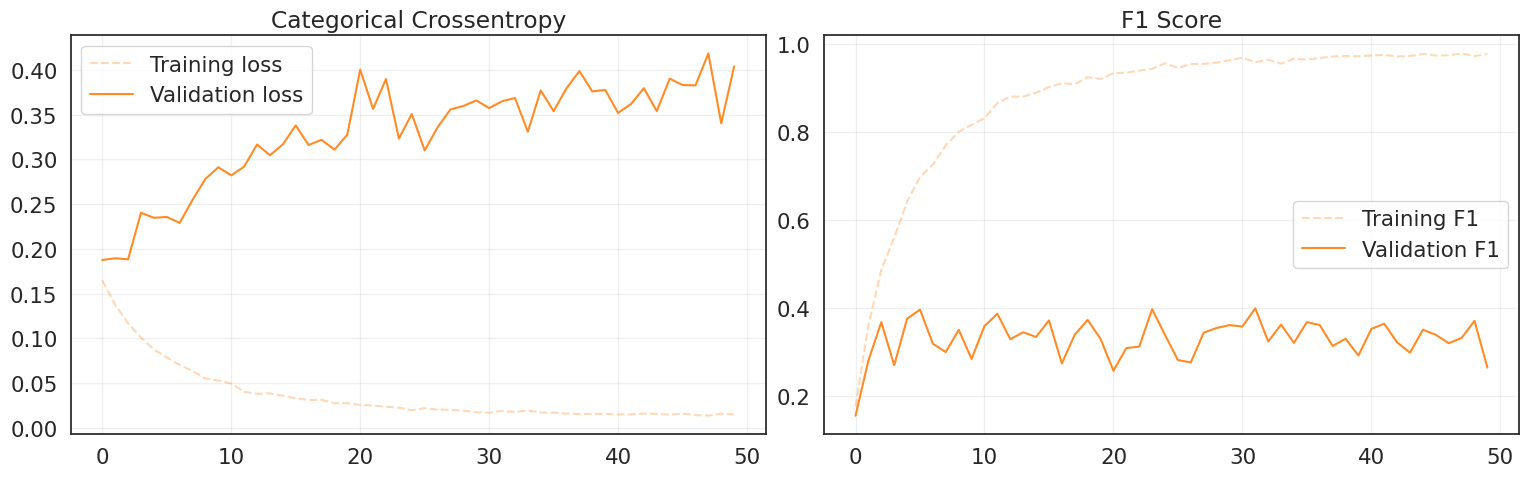

In [50]:
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(history['train_loss'], label = "Training loss",   alpha = 0.3, color = "#ff7f0e", linestyle = "--")
ax1.plot(history['val_loss'],   label = "Validation loss", alpha = 0.9, color = "#ff7f0e")
ax1.set_title("Categorical Crossentropy")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation F1 score on the second axis
ax2.plot(history['train_f1'], label = "Training F1",   alpha = 0.3, color = "#ff7f0e", linestyle = "--")
ax2.plot(history['val_f1'],   label = "Validation F1", alpha = 0.9, color = "#ff7f0e")
ax2.set_title("F1 Score")
ax2.legend()
ax2.grid(alpha = 0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right = 0.85)
plt.show()

PATCH-LEVEL METRICS
Accuracy over the validation set:  0.3484
Precision over the validation set: 0.3469
Recall over the validation set:    0.3484
F1 score over the validation set:  0.3452


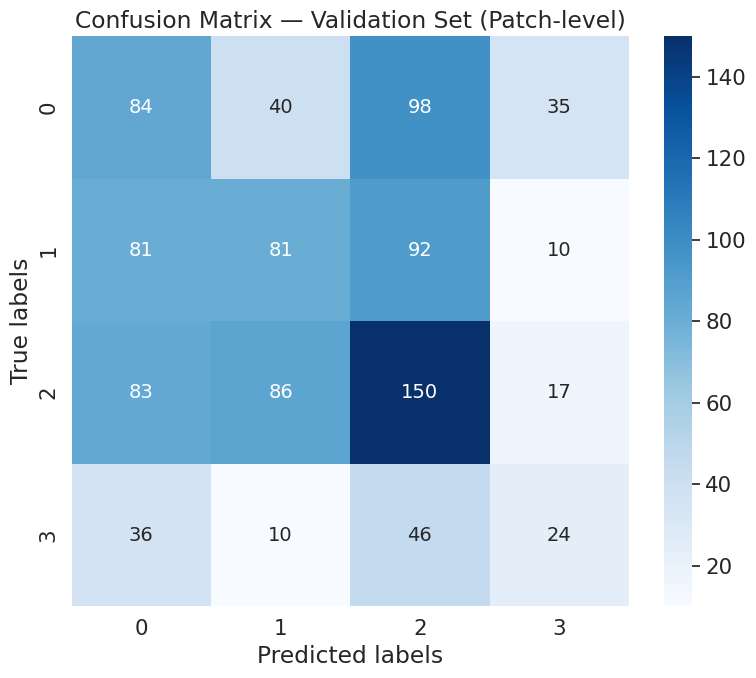

In [51]:
val_preds = []
val_targets = []

model.eval()

with torch.no_grad():  # Disable gradient computation for inference
    for batch in val_loader:
        # Unpack batch: (img_id, inputs, targets) oppure (inputs, targets)
        if len(batch) == 3:
            img_ids, inputs, targets = batch
        else:
            inputs, targets = batch

        inputs  = inputs.to(device)
        targets = targets.to(device)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type = device.type,
                                enabled = (device.type == "cuda")):
            logits = model(inputs)
            loss = criterion(logits, targets)  # loss qui non la usi, ma ok per debug

        # Accumulate metrics (PATCH-LEVEL)
        preds = logits.argmax(dim = 1)

        # Store batch results on CPU
        val_preds.append(preds.cpu().numpy())
        val_targets.append(targets.cpu().numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics (PATCH-LEVEL)
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average = "weighted")
val_rec = recall_score(val_targets, val_preds, average = "weighted")
val_f1 = f1_score(val_targets, val_preds, average = "weighted")

print("PATCH-LEVEL METRICS")
print(f"Accuracy over the validation set:  {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set:    {val_rec:.4f}")
print(f"F1 score over the validation set:  {val_f1:.4f}")

# Confusion matrix (PATCH-LEVEL)
cm = confusion_matrix(val_targets, val_preds)

labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

plt.figure(figsize = (8, 7))
sns.heatmap(cm, annot = labels, fmt = "", cmap = "Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix — Validation Set (Patch-level)")
plt.tight_layout()
plt.show()


IMAGE-LEVEL METRICS (patch aggregation)
Accuracy over the validation set:  0.4017
Precision over the validation set: 0.4332
Recall over the validation set:    0.4017
F1 score over the validation set:  0.3992


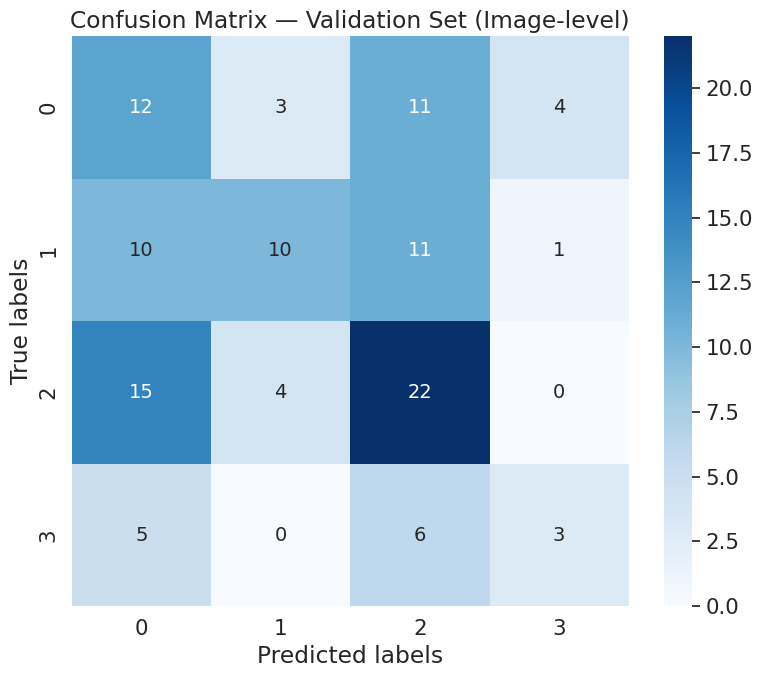

In [52]:
# ============================
# IMAGE-LEVEL VALIDATION METRICS
# ============================

model.eval()

# Accumulator per aggregare le predizioni dei patch di ogni immagine
image_probs = {}    # img_id -> list di vettori di probabilità (uno per patch)
image_targets = {}  # img_id -> singola etichetta ground-truth

with torch.no_grad():  # Disable gradient computation for inference
    for batch in val_loader:
        # Unpack batch: (img_id, inputs, targets)
        if len(batch) == 3:
            img_ids, inputs, targets = batch
        else:
            # Fallback per compatibilità, ma in pratica qui ci aspettiamo 3 elementi
            inputs, targets = batch
            img_ids = [None] * inputs.size(0)

        inputs  = inputs.to(device)
        targets = targets.to(device)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type = device.type,
                                enabled = (device.type == "cuda")):
            logits = model(inputs)

        # Convert logits to probabilities on CPU
        probs = torch.softmax(logits, dim = 1).cpu().numpy()
        targets_np = targets.cpu().numpy()

        # Accumula per img_id
        for img_id, p, t in zip(img_ids, probs, targets_np):
            # img_id può essere tensor → converti a int Python
            if isinstance(img_id, torch.Tensor):
                img_id = img_id.item()

            # Se per qualche motivo fosse None, usa una chiave fittizia unica
            if img_id is None:
                img_id = id(p)

            if img_id not in image_probs:
                image_probs[img_id] = []
                image_targets[img_id] = t

            image_probs[img_id].append(p)

# -----------------------------------------------
# Aggregazione: media delle probabilità per immagine
# -----------------------------------------------
val_img_preds = []
val_img_targets = []

for img_id in image_probs:
    mean_prob = np.mean(image_probs[img_id], axis = 0)  # media sui patch
    pred = np.argmax(mean_prob)
    target = image_targets[img_id]

    val_img_preds.append(pred)
    val_img_targets.append(target)

val_img_preds   = np.array(val_img_preds)
val_img_targets = np.array(val_img_targets)

# Metriche IMAGE-LEVEL
val_acc_img  = accuracy_score(val_img_targets, val_img_preds)
val_prec_img = precision_score(val_img_targets, val_img_preds, average = "weighted")
val_rec_img  = recall_score(val_img_targets, val_img_preds, average = "weighted")
val_f1_img   = f1_score(val_img_targets, val_img_preds, average = "weighted")

print("IMAGE-LEVEL METRICS (patch aggregation)")
print(f"Accuracy over the validation set:  {val_acc_img:.4f}")
print(f"Precision over the validation set: {val_prec_img:.4f}")
print(f"Recall over the validation set:    {val_rec_img:.4f}")
print(f"F1 score over the validation set:  {val_f1_img:.4f}")

# Confusion matrix IMAGE-LEVEL
cm_img = confusion_matrix(val_img_targets, val_img_preds)
labels_img = np.array([f"{num}" for num in cm_img.flatten()]).reshape(cm_img.shape)

plt.figure(figsize = (8, 7))
sns.heatmap(cm_img, annot = labels_img, fmt = "", cmap = "Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix — Validation Set (Image-level)")
plt.tight_layout()
plt.show()


## 🕹️ **Inference**

In [53]:
test_probs = []
test_img_ids = []

model.eval()

with torch.no_grad():
    for batch in test_loader:
        if len(batch) == 2:
            img_ids, inputs = batch
        else:
            (inputs,) = batch
            img_ids = [None] * inputs.size(0)

        inputs = inputs.to(device)

        with torch.amp.autocast(device_type = device.type,
                                enabled = (device.type == "cuda")):
            logits = model(inputs)

        probs = F.softmax(logits, dim = 1).cpu().numpy()

        test_probs.append(probs)
        test_img_ids.extend(list(img_ids))

test_probs = np.concatenate(test_probs, axis = 0)


In [54]:
# Count how many patches per sample_index
patches_per_sample = X_c_test.groupby('sample_index').size().to_dict()

# Initialize vector of final label predictions
test_preds = []
pointer = 0

# Get label prediction for each sample
for sample_index in X_c_test['sample_index'].unique():
    n_patches = patches_per_sample[sample_index]

    # Extract the contiguous block of predictions
    sample_patch_probs = test_probs[pointer:pointer + n_patches]
    pointer += n_patches

    # Get mean probability for each label
    mean_probs = sample_patch_probs.mean(axis = 0)

    # Pick the label with highest probability
    final_label = np.argmax(mean_probs)
    test_preds.append((sample_index, final_label))

In [55]:
sample_indexes, numeric_preds = zip(*test_preds)

# Convert numeric predictions to strings
labels = [int_to_label [p] for p in numeric_preds]

# Build DataFrame
results = pd.DataFrame({
    "sample_index": sample_indexes,
    "label": labels
})

In [56]:
from google.colab import files

# Save CSV locally in the Colab environment
results.to_csv("test_labels_mask.csv", index=False)

# Download to your device
files.download("test_labels_mask.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>